<img src="logo.png" alt="La poule qui chante" style="width: 400px;" align="left"/>


# Contexte
Vous travaillez chez La poule qui chante, une entreprise française d’agroalimentaire. Elle souhaite se développer à l'international.<br>
L'international, oui, mais pour l'instant, le champ des possibles est bien large : aucun pays particulier ni aucun continent n'est pour le moment choisi. Tous les pays sont envisageables !

# Initialisation du projet

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats as st

#Librairies utiliséees pour l'analyse
#Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering # pour faire du clustering
from sklearn.metrics import silhouette_score # poour calculer le cof de silhouette

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#Calcul coeff Cophenet
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Visualisation coude et silhouette
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Calcul distorsion
from scipy.spatial.distance import cdist 

#ACP
#from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Impute Nan values
from sklearn.impute import KNNImputer 

#from functions import plot_dendrogram


from termcolor import colored # to format text


## Paramètres

In [2]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns', 20)

## Import des fichiers

In [3]:
path='./Fichiers/'
food_avail=pd.read_csv(path+"DisponibiliteAlimentaire_2017.csv")
population=pd.read_csv(path+"Population_2000_2018.csv")
region=pd.read_excel(path+"List_of_countries.xlsx")

## Variables
Besoin journaliers en protéines
L’ANR en protéines est de 0,8 g de protéines par kg de poids corporel par jour chez les adultes. 
Cela représente la quantité minimum de protéines qui permet d’éviter la perte de masse corporelle maigre.<br>
Cette valeur ne concerne que la tranche des adultes qui représente 65,43% ([source](https://donnees.banquemondiale.org/indicator/SP.POP.65UP.TO.ZS?end=2017&start=1960)) de la population, mais est trop basse pour les autres tranches d'âge.<br>
Nous utiliserons tout de même cette donnée.

D'après le BMC Pubmic Health, le poids moyen est quant à lui de 62kg ([Source](http://webcache.googleusercontent.com/search?q=cache:eOMWwpP7KKEJ:https://politiquedesante.fr/poids-de-lhumanite/&client=firefox-b-d&hl=fr&gl=fr&strip=1&vwsrc=0)).

Ce qui donne un apport recommandé de 62 * 0.8 = 49.6 grammes par jour et par humain.

In [4]:
prot=49.6

## Fonctions

In [5]:
def mean_and_standard_deviation_info(X) :

    ''' 
    Displays the mean and std of a datadrame
    Parameters : dataframe
    '''

# Observation des moyennes et écart-types du tableau
    return print (
f'''Moyennes:
{X.mean()}

Ecart-type :
{X.std()}
''')


In [6]:
def plot_dendrogram(data, Z, threshold):
    '''
    Plot dendrogram
    Parameters : 
        - data = data centered and reduced
        - method = the dendrogram method (see linkage doc)
        - metric = the dendrogram metric (see linkage doc)
        - threshold = where I cut my tree to have the number of classification thah I've chosen after 1st observation, the max distance.
    '''
#Z = linkage(data, method=method,metric=metric)

    # Show dendrogram
    fig = plt.figure(figsize=(30, 15))
    c, coph_dists = cophenet(Z, pdist(data))
    plt.title(f'CAH avec matérialisation des classes - cophenet coefficient = {c:.3}', loc='center', fontsize=20, fontweight=0, pad=20)

    dendrogram(Z,labels= names ,orientation='top',color_threshold=threshold,leaf_font_size=12)

    plt.axhline(y=threshold,linestyle = '--') # To materialize the cutting, we use the threshold which cuts the dendogram on the axis of the Ward method.
    plt.show()

In [7]:
def display_countries_from_clusters(number_of_clusters, groups):
    '''
    Displays the countries of each cluster
    Parameters : 
        - Number of clusters (see colored classes on dendrogram to know the number)
        - Groups of countries
        '''
    print(f"Affichage des {number_of_clusters} clusters")
    print("")
    for i in range(1,len(np.unique(groups))+1):
        print(f"Cluster {i} :")
        print(f", ".join(main_df.index[groups == i].sort_values()))
        print(" ")


In [8]:
def build_plot(data_frame,var, clustering_method):
    """
    Fonction pour croiser des variables qualitatives 
    et quantitatives en fonction d'une variable qualitative.
    """
    
    #if (np.issubdtype(dfdata[explicative].dtype, np.number)) :
    plt.figure(figsize=(10,5))
    sns.boxplot(data=data_frame,x=var,y=clustering_method,orient="h")

    plt.xlabel(var,fontsize=10)
    plt.ylabel(clustering_method,fontsize=10)
    plt.title(var + " selon " + clustering_method ,fontsize=15, pad=20)
    '''else :
        pd.crosstab(dfdata[a_expliquer], dfdata[explicative])\
        .apply(lambda r: r/r.sum(), axis=1).plot(kind='barh',stacked=True,legend=False, color=colorsmod,  figsize=(12,4))
        plt.figure(figsize=(6,3))
        plt.xlabel(explicative,fontsize=10)
        plt.ylabel(a_expliquer,fontsize=10)
        plt.title(explicative + " selon " + a_expliquer,fontsize=15)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))'''

In [9]:
def display_scree_plot(ratio_var, ratio_var_cumsum):
    '''
    Diagramme décrivant le pourcentage d'intertie totale associé à chaque axe : c'est le diagramme de l'éboulis des valeurs propres.
    On affiche également la somme cumulée des inerties et la visualisation de l'éboulis en ligne pour voir le coude.
    '''
    #ratio_var= pca.explained_variance_ratio_*100 # Pourcentage de variance cumulé expliqué par les n premières composantes.
    plt.bar(np.arange(len(ratio_var)), ratio_var, label="Scree of eigen values")
    plt.plot(np.arange(len(ratio_var)), ratio_var_cumsum,c="red",marker='o', label="Scree of eigen values")
    plt.plot(np.arange(len(ratio_var)), ratio_var,c="purple",marker='_', label="Elbow viz")
    
    plt.xlabel("Number of components")
    plt.ylabel("Percentage of explained variance",)
    plt.title("Scree of eigen values and elbow viz")
    plt.xticks(range(len(ratio_var)))
    plt.legend()
    plt.show()
    

In [10]:
def display_factorial_planes(X_projected, n_comp,  axis_ranks, alpha=1, pca=None,illustrative_var=None, labels=None, title_type=None,title_nb_of_indiv=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize=(30,30))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=200)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=200)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    if not str(labels[i]).isdigit():
                        plt.text(x, y, labels[i][:8],# je raccourcie le nom du pays
                              fontsize='12', ha='center',va='center') 
                    else:
                        plt.text(x, y, labels[i],
                              fontsize='12', ha='center',va='center') 
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            
            # appel de la fonction de tracé de cercle pour observer les variables qui sont dedans et en dehors.
            draw_circle()
            
            # nom des axes, avec le pourcentage d'inertie expliqué quand on a la variable pca
            if pca is None:
                plt.xlabel('F1')
                plt.ylabel('F2')
            else:
                plt.xlabel('F{} ({}%)'.format(d1+1, round(pca.eig_[1][d1],1)))
                plt.ylabel('F{} ({}%)'.format(d2+1, round(pca.eig_[2][d2],1)))

            plt.title(f"Projection des {title_nb_of_indiv} {title_type} sur le 1er plan factoriel")         
            plt.legend(loc="upper right",title="Clusters", title_fontsize=16, fontsize=12)
            plt.show(block=False)

In [11]:
def draw_circle():
    '''
    Tracé d'un cercle de diamètre 1
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=1 )  # Add a unit circle for scale

In [12]:
def build_clustermap(df,clustering_method):
    ''' 
    Method to build the clustermap
    Parameters : 
        - df = dataframe to plot
        - clustering method = the clustering method used
    '''
    df=df.groupby(clustering_method).agg('median')
    cm=sns.clustermap(df,standard_scale=1,cmap = 'Blues', figsize=(15,15))
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0)  
    plt.setp(cm.ax_heatmap.get_xticklabels(), rotation=70) 
    plt.title("Clustermap sur " + clustering_method, loc="right", fontsize=30, pad=20)
    plt.savefig("img/"+clustering_method+".png", dpi=200, bbox_inches="tight")#, facecolor="white")
    plt.show()

In [13]:
def best_linkage_ach(data):
    '''
    Determines the best theoritical linkage method
    Parameters : 
     - the data centered and reduced
    '''

    methods = ['single' ,'complete' ,'average' ,'weighted' , 'centroid' ,'median' ,'ward' ]
    coef=[]
    for method in ((methods)) :
        Z = linkage(data, method=method,metric='euclidean')
        c, coph_dists = cophenet(Z, pdist(data))
        coef.append([method,c])
        plt.bar(method,c)
    plt.title("Coefficient cophénétique par type de lien")
    plt.show()

    coef_df = pd.DataFrame(coef, columns = ['Linkage type', 'Coef'])
    coef_max=max(coef_df.Coef)

    optimal_method=coef_df.loc[(coef_df["Coef"]==coef_max),'Linkage type'].item()
    print (f"La meilleure méthode théorique de lien est la '{optimal_method}'.")

# Les données

## Analyse de la qualité des données

### Type des données

In [14]:
food_avail.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

In [15]:
population.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
Note                       object
dtype: object

### Valeurs manquantes ou nulles

In [16]:
food_avail.isnull().sum()

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

In [17]:
population.isnull().sum()

Code Domaine                 0
Domaine                      0
Code zone                    0
Zone                         0
Code Élément                 0
Élément                      0
Code Produit                 0
Produit                      0
Code année                   0
Année                        0
Unité                        0
Valeur                       0
Symbole                      0
Description du Symbole       0
Note                      4153
dtype: int64

**⚠ Observation**<br>
Le champ *Note* n'a pas de données mais ça n'a pas d'importance.

### Recherche d'anomalies

In [18]:
food_avail.describe()

,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,176600.000000,176600.000000,176600.000000,176600.0,176600.0,176600.000000
mean,125.474740,3810.052894,2628.778545,2017.0,2017.0,210.554918
std,72.941699,2211.790089,91.993247,0.0,0.0,4762.047787
min,1.000000,645.000000,2511.000000,2017.0,2017.0,-10388.000000
25%,63.000000,684.000000,2556.000000,2017.0,2017.0,0.000000
50%,120.000000,5142.000000,2612.000000,2017.0,2017.0,0.120000
75%,188.000000,5301.000000,2732.000000,2017.0,2017.0,8.462500
max,276.000000,5911.000000,2899.000000,2017.0,2017.0,758548.000000


In [19]:
population.describe()

,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,4411.000000,4411.0,4411.0,4411.000000,4411.000000,4.411000e+03
mean,132.202902,511.0,3010.0,2009.068238,2009.068238,2.963004e+04
std,75.854840,0.0,0.0,5.481539,5.481539,1.238029e+05
min,1.000000,511.0,3010.0,2000.000000,2000.000000,7.850000e-01
25%,68.000000,511.0,3010.0,2004.000000,2004.000000,3.921890e+02
50%,132.000000,511.0,3010.0,2009.000000,2009.000000,4.764741e+03
75%,195.000000,511.0,3010.0,2014.000000,2014.000000,1.821548e+04
max,299.000000,511.0,3010.0,2018.000000,2018.000000,1.427648e+06


### Nettoyage des données

**Mode opératoire**<br>
- Je me débarasse des lignes qui ne m'intéresse pas :
    - Années autres que 2007 et 2017 pour la population
    - Les données alimentaires qui n'ont pas de rapport avec la volaille
    - Les éléments non utiles à l'analyse
- Je recherche les colonnes qui ont une valeur unique, ou avec peu de valeurs distinctes pour en supprimer les colonnes.

In [20]:
population

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2014,2014,1000 personnes,13586.707,X,Sources internationales sûres,NaN
4407,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,13814.629,X,Sources internationales sûres,NaN
4408,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2016,2016,1000 personnes,14030.331,X,Sources internationales sûres,NaN
4409,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,14236.595,X,Sources internationales sûres,NaN


In [21]:
food_avail

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.00,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.00,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.00,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.00,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.00,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176595,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2899,Miscellanees,2017,2017,Milliers de tonnes,19.00,S,Données standardisées
176596,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/personne/an),2899,Miscellanees,2017,2017,kg,1.33,Fc,Donnée calculée
176597,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2899,Miscellanees,2017,2017,Kcal/personne/jour,1.00,Fc,Donnée calculée
176598,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/personne/jour),2899,Miscellanees,2017,2017,g/personne/jour,0.04,Fc,Donnée calculée


**Année autre que 2007 et 2017 - fichier population**<br>
L'idée est de calculer l'évolution de la population sur 10 ans pour avoir une tendance du développement des pays.<br>
Ca va me donner une information **Sociologique** sur la population.

In [22]:
evo_pop = population[(population["Année"]==2017) | (population["Année"]==2007)].copy()
evo_pop = evo_pop.loc[:,["Zone","Valeur", "Année","Code zone"]]
evo_pop=evo_pop.pivot_table(index=["Zone", "Code zone"],columns=["Année"], values="Valeur").reset_index().rename_axis(None, axis=1)

In [23]:
evo_pop

,Zone,Code zone,2007,2017
0,Afghanistan,2,27100.536,36296.113
1,Afrique du Sud,202,49119.759,57009.756
2,Albanie,3,3033.998,2884.169
3,Algérie,4,34166.972,41389.189
4,Allemagne,79,81277.830,82658.409
...,...,...,...,...
232,Îles Salomon,25,492.132,636.039
233,Îles Turques-et-Caïques,224,30.385,37.115
234,Îles Vierges américaines,240,107.115,104.751
235,Îles Vierges britanniques,239,25.047,29.577


Je multiplie le résultat par 10 pour avoir le pourcentage moyen d'évolution par an sur les 10 ans

In [24]:
evo_pop["Evolution pop (%)"] = round(((evo_pop[2017]-evo_pop[2007]) / evo_pop[2007])*10,2)

J'ajoute la région de chaque pays au fichier

In [25]:
evo_pop=evo_pop.merge(region,how="left", left_on="Code zone", right_on="Code Pays")

In [26]:
evo_pop

,Zone,Code zone,2007,2017,Evolution pop (%),Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
0,Afghanistan,2,27100.536,36296.113,3.39,5300,Asie,2,Afghanistan,4.0,AF,AFG
1,Afrique du Sud,202,49119.759,57009.756,1.61,5100,Afrique,202,Afrique du Sud,710.0,ZA,ZAF
2,Albanie,3,3033.998,2884.169,-0.49,5400,Europe,3,Albanie,8.0,AL,ALB
3,Algérie,4,34166.972,41389.189,2.11,5100,Afrique,4,Alg?rie,12.0,DZ,DZA
4,Allemagne,79,81277.830,82658.409,0.17,5400,Europe,79,Allemagne,276.0,DE,DEU
...,...,...,...,...,...,...,...,...,...,...,...,...
232,Îles Salomon,25,492.132,636.039,2.92,5500,Oc?anie,25,?les Salomon,90.0,SB,SLB
233,Îles Turques-et-Caïques,224,30.385,37.115,2.21,5200,Am?riques,224,?les Turques-et-Ca?ques,796.0,TC,TCA
234,Îles Vierges américaines,240,107.115,104.751,-0.22,5200,Am?riques,240,?les Vierges am?ricaines,850.0,VI,VIR
235,Îles Vierges britanniques,239,25.047,29.577,1.81,5200,Am?riques,239,?les Vierges britanniques,92.0,VG,VGB


Je ne conserve que les colonnes qui m'intéressent

In [27]:
evo_pop=evo_pop.loc[:,["Zone","Evolution pop (%)", "Groupe de pays"]]

**Recherche des produits liés au poulet - fichier alimentation**

La Viande de Volailles regroupe les différents produits suivants (source FAO : [Cultures et produits animaux](https://www.fao.org/faostat/fr/#data/TCL)) : <br>
"Abats et foie de volaille", "Abats et foies de canard", "Abats et foies d'oie", "Foie gras, préparations", "Viande, canard", "Viande, dinde", "Viande, oie", "Viande, poulet en boîte", "Viande, volaille".<br>
Comme nous n'avons pas de granularité au poulet dans les données de bilan alimentaure, on reste sur le cas général Viande de Volailles.

In [28]:
produit = food_avail["Produit"].str.lower()
mask = np.column_stack([produit.str.contains(r"volaille|poule", na=False)])
poultry_meat=food_avail.loc[mask.any(axis=1)].copy()

In [29]:
poultry_meat.sample(5)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
134374,FBS,Nouveaux Bilans Alimentaire,37,République centrafricaine,684,Disponibilité de matière grasse en quantité (g/personne/jour),2734,Viande de Volailles,2017,2017,g/personne/jour,0.48,Fc,Donnée calculée
38138,FBS,Nouveaux Bilans Alimentaire,50,Chypre,5911,Exportations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,1.00,S,Données standardisées
28227,FBS,Nouveaux Bilans Alimentaire,35,Cabo Verde,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,12.00,S,Données standardisées
125884,FBS,Nouveaux Bilans Alimentaire,166,Panama,674,Disponibilité de protéines en quantité (g/personne/jour),2734,Viande de Volailles,2017,2017,g/personne/jour,10.34,Fc,Donnée calculée
66603,FBS,Nouveaux Bilans Alimentaire,84,Grèce,5142,Nourriture,2734,Viande de Volailles,2017,2017,Milliers de tonnes,162.00,S,Données standardisées


Top et flop consommateurs de volaille

In [30]:
food_avail.loc[(food_avail["Élément"]=="Disponibilité alimentaire en quantité (kg/personne/an)") & (food_avail["Produit"]=="Viande de Volailles"),["Zone","Valeur"]].sort_values("Valeur", ascending=False)

,Zone,Valeur
146030,Saint-Vincent-et-les Grenadines,72.31
82807,Israël,67.39
147000,Samoa,64.77
144113,Sainte-Lucie,56.69
145055,Saint-Kitts-et-Nevis,55.77
...,...,...
118060,Nigéria,1.01
116988,Niger,0.94
89400,Kenya,0.67
160392,Tchad,0.45


In [31]:
print (f"""Avant modification, le fichier population contenait {population.shape[0]} lignes et {population.shape[1]} colonnes.
Maintenant, le fichier contient {evo_pop.shape[0]} lignes et {evo_pop.shape[1]} colonnes.

Le fichier alimentation était composé de {food_avail.shape[0]} lignes et {food_avail.shape[1]} colonnes.
Il est maintenant constitué de {poultry_meat.shape[0]} lignes et {poultry_meat.shape[1]} colonnes.""")

Avant modification, le fichier population contenait 4411 lignes et 15 colonnes.
Maintenant, le fichier contient 237 lignes et 3 colonnes.

Le fichier alimentation était composé de 176600 lignes et 14 colonnes.
Il est maintenant constitué de 2061 lignes et 14 colonnes.


Je transpose mon fichier poultry_meat pour avoir les pays en index, et les éléments en colonnes. 

In [32]:
poultry_meat=poultry_meat.pivot(values="Valeur",index="Zone",columns="Élément")\
.reset_index()\
.rename(columns={'Disponibilité intérieure':'Dispo int. volaille','Disponibilité alimentaire (Kcal/personne/jour)': 'Dispo énerg. volaille (kcal/pers/jour)',\
                 'Disponibilité de protéines en quantité (g/personne/jour)': 'Dispo prot volaille(g/pers/jour)','Exportations - Quantité' : 'Exportation de volaille',\
                 'Importations - Quantité' : 'Importation de volaille', 'Nourriture' : 'Nourriture de volaille', 'Production' : 'Production de volaille',\
                 'Alimentation pour touristes':'Alimentation de volaille pour touristes', 'Variation de stock' : 'Variation de stock volaille',\
                 'Pertes' :'Pertes volaille','Résidus':'Résidus volaille', 'Traitement':'Traitement volaille','Autres utilisations (non alimentaire)':'Autres utilisations (non alimentaire) volaille'})\
.rename_axis(None, axis=1) # rename_axis to delete the name of the index that is "Élément" after pivot

Je regarde s'il y a des valeurs nulles

In [33]:
poultry_meat.isnull().sum()

Zone                                                               0
Alimentation de volaille pour touristes                           94
Aliments pour animaux                                            171
Autres utilisations (non alimentaire) volaille                   138
Dispo énerg. volaille (kcal/pers/jour)                             0
Disponibilité alimentaire en quantité (kg/personne/an)             0
Disponibilité de matière grasse en quantité (g/personne/jour)      0
Dispo prot volaille(g/pers/jour)                                   0
Dispo int. volaille                                                2
Exportation de volaille                                           37
Importation de volaille                                            2
Nourriture de volaille                                             2
Pertes volaille                                                  105
Production de volaille                                             4
Résidus volaille                  

Je supprime les 2 colonnes qui n'ont que des valeurs nulles, 'Semences' et 'Aliments pour animaux', ainsi que : 
- 'Dispo énerg. volaille (kcal/pers/jour)'
- 'Disponibilité alimentaire en quantité (kg/personne/an)'
- 'Disponibilité de matière grasse en quantité (g/personne/jour)'>

In [34]:
poultry_meat.drop(columns=['Disponibilité alimentaire en quantité (kg/personne/an)','Dispo énerg. volaille (kcal/pers/jour)',\
                           'Disponibilité de matière grasse en quantité (g/personne/jour)','Aliments pour animaux', 'Semences'], inplace=True)
#'Disponibilité intérieure','''
#'Variation de stock','Pertes', 'Résidus', 'Disponibilité de matière grasse en quantité (g/personne/jour)','Traitement', 'Autres utilisations (non alimentaire)','Aliments pour animaux', 'Semences']

In [35]:
poultry_meat#.rename_axis(None, axis=1)

,Zone,Alimentation de volaille pour touristes,Autres utilisations (non alimentaire) volaille,Dispo prot volaille(g/pers/jour),Dispo int. volaille,Exportation de volaille,Importation de volaille,Nourriture de volaille,Pertes volaille,Production de volaille,Résidus volaille,Traitement volaille,Variation de stock volaille
0,Afghanistan,NaN,NaN,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,0.0
1,Afrique du Sud,0.0,NaN,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,-0.0
2,Albanie,NaN,NaN,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,4.0
3,Algérie,0.0,NaN,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,0.0
4,Allemagne,NaN,NaN,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,NaN,NaN,14.80,412.0,94.0,433.0,412.0,NaN,48.0,-0.0,NaN,-26.0
168,Équateur,0.0,NaN,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,NaN,-1.0
169,États-Unis d'Amérique,NaN,89.0,19.93,18266.0,3692.0,123.0,18100.0,NaN,21914.0,-0.0,77.0,80.0
170,Éthiopie,0.0,NaN,0.04,14.0,NaN,1.0,14.0,1.0,14.0,0.0,NaN,0.0


Pour ne pas me gêner dans les calculs, je remplace les valeurs Nan par des 0 : lorsque la valeur n'est pas présente, je n'additionnerai rien, donc 0.

In [36]:
poultry_meat=poultry_meat.fillna(0)

## Ajout de nouvelles données

### Calcul de données

On somme la totalité des informations pour pouvoir comparer les données volailles à la totalité des aliments.

In [37]:
food_avail

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.00,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.00,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.00,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.00,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.00,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176595,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2899,Miscellanees,2017,2017,Milliers de tonnes,19.00,S,Données standardisées
176596,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/personne/an),2899,Miscellanees,2017,2017,kg,1.33,Fc,Donnée calculée
176597,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2899,Miscellanees,2017,2017,Kcal/personne/jour,1.00,Fc,Donnée calculée
176598,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/personne/jour),2899,Miscellanees,2017,2017,g/personne/jour,0.04,Fc,Donnée calculée


In [38]:
food_avail_total=food_avail.copy()
food_avail_total=food_avail_total.pivot_table(index="Zone",columns="Élément", values="Valeur",aggfunc=np.sum)\
.reset_index().rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)': 'Dispo prot. totale (g/pers/jour)'}).rename_axis(None, axis=1)

In [39]:
food_avail_total=food_avail_total.loc[:,['Zone','Dispo prot. totale (g/pers/jour)']]

### Données Politiques et Economiques et autres

- Fichier political_stability - Récupération de la stabilité politique - moyenne années 2007 à 2017 : Dimension **Politique**.<br> 
- Fichier additional_info
    - Récupération du PIB en US$ par pays - année 2017 : Dimension **Economique**.<br>
    - Part de protéines animales par pays.<br>

In [40]:
political_stability=pd.read_excel(path+"Stabilite_Politique_2007-2017.xlsx")
political_stability

,Domaine,Zone,Élément,Produit,Année,Valeur
0,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2007,-2.41
1,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2008,-2.69
2,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2009,-2.71
3,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2010,-2.58
4,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2011,-2.50
...,...,...,...,...,...,...
2239,Données de la sécurité alimentaire,Zimbabwe,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2013,-0.67
2240,Données de la sécurité alimentaire,Zimbabwe,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2014,-0.71
2241,Données de la sécurité alimentaire,Zimbabwe,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2015,-0.62
2242,Données de la sécurité alimentaire,Zimbabwe,Valeur,Stabilité politique et absence de violence/terrorisme (indice),2016,-0.62


In [41]:
political_stability.drop(columns=["Domaine","Élément","Produit"], inplace=True)

In [42]:
political_stability=political_stability.groupby(["Zone"], as_index=False).agg({"Valeur":'mean'})
political_stability.rename(columns={"Valeur":"Stabilité politique"}, inplace=True)
political_stability["Stabilité politique"]=round(political_stability["Stabilité politique"],2)
political_stability

,Zone,Stabilité politique
0,Afghanistan,-2.57
1,Afrique du Sud,-0.06
2,Albanie,0.07
3,Algérie,-1.17
4,Allemagne,0.82
...,...,...
199,États-Unis d'Amérique,0.52
200,Éthiopie,-1.58
201,Îles Cook,1.23
202,Îles Marshall,0.98


In [43]:
additional_info=pd.read_excel(path+"Infos complementaires.xlsx")

In [44]:
additional_info

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Valeur
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6123,Valeur,21014,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),20162018,2016-2018,10.7
1,FS,Données de la sécurité alimentaire,2,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2017)",2017,2017,2058.4
2,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6123,Valeur,21014,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),20162018,2016-2018,35.7
3,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2017)",2017,2017,13860.3
4,FS,Données de la sécurité alimentaire,3,Albanie,6123,Valeur,21014,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),20162018,2016-2018,61.0
...,...,...,...,...,...,...,...,...,...,...,...
403,FS,Données de la sécurité alimentaire,249,Yémen,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2017)",2017,2017,2300.0
404,FS,Données de la sécurité alimentaire,251,Zambie,6123,Valeur,21014,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),20162018,2016-2018,13.7
405,FS,Données de la sécurité alimentaire,251,Zambie,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2017)",2017,2017,3485.0
406,FS,Données de la sécurité alimentaire,181,Zimbabwe,6123,Valeur,21014,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),20162018,2016-2018,NaN


In [45]:
additional_info=additional_info.pivot_table(index="Zone",columns="Produit", values="Valeur")\
.reset_index()\
.rename(columns={"Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)": "Dispo prot. animale (g/pers/jour)",\
        "PIB par habitant, ($ PPA internationaux constants de 2017)" : "PIB par hab.",\
        })\
.rename_axis(None, axis=1)


In [46]:
additional_info

,Zone,Dispo prot. animale (g/pers/jour),PIB par hab.
0,Afghanistan,10.7,2058.4
1,Afrique du Sud,35.7,13860.3
2,Albanie,61.0,12771.0
3,Algérie,25.0,11737.4
4,Allemagne,63.0,53071.5
...,...,...,...
190,Équateur,30.7,11617.9
191,États-Unis d'Amérique,73.0,59914.8
192,Éthiopie,6.0,2021.6
193,Îles Marshall,NaN,3711.4


## Fusion des différents fichiers

On a 5 dataframes à ce stade : 
- evo_pop
- poultry_meat
- food_avail_total
- additional_info
- political_stability


In [47]:
file_list = [evo_pop,poultry_meat,food_avail_total,additional_info, political_stability]
names_list = ["evo_pop","poultry_meat","food_avail_total","additional_info","political_stability"]

In [48]:
for var, name in zip(file_list, names_list):
    print (f"Le fichier {name} contient {var.shape[0]} lignes")

Le fichier evo_pop contient 237 lignes
Le fichier poultry_meat contient 172 lignes
Le fichier food_avail_total contient 174 lignes
Le fichier additional_info contient 195 lignes
Le fichier political_stability contient 204 lignes


**Observation**<br>
Le fichier qui nous intéresse est celui qui contient des données sur la volaille. On va  faire une jointure gauche sur ce fichier pour garder toutes ces lignes.

In [49]:
temp_df=poultry_meat.merge(evo_pop,how="left")

In [50]:
temp_df=temp_df.merge(food_avail_total,how="left")

In [51]:
temp_df=temp_df.merge(additional_info, how="left")

In [52]:
temp_df=temp_df.merge(political_stability, how="left")

In [53]:
temp_df.set_index('Zone', inplace=True)
temp_df

,Alimentation de volaille pour touristes,Autres utilisations (non alimentaire) volaille,Dispo prot volaille(g/pers/jour),Dispo int. volaille,Exportation de volaille,Importation de volaille,Nourriture de volaille,Pertes volaille,Production de volaille,Résidus volaille,Traitement volaille,Variation de stock volaille,Evolution pop (%),Groupe de pays,Dispo prot. totale (g/pers/jour),Dispo prot. animale (g/pers/jour),PIB par hab.,Stabilité politique
Zone,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.54,57.0,0.0,29.0,55.0,2.0,28.0,0.0,0.0,0.0,3.39,Asie,54.09,10.7,2058.4,-2.57
Afrique du Sud,0.0,0.0,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,0.0,-0.0,1.61,Afrique,83.36,35.7,13860.3,-0.06
Albanie,0.0,0.0,6.26,47.0,0.0,38.0,47.0,0.0,13.0,0.0,0.0,4.0,-0.49,Europe,119.50,61.0,12771.0,0.07
Algérie,0.0,0.0,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,0.0,0.0,2.11,Afrique,92.85,25.0,11737.4,-1.17
Allemagne,0.0,0.0,7.96,1739.0,646.0,842.0,1609.0,0.0,1514.0,-38.0,167.0,-29.0,0.17,Europe,104.07,63.0,53071.5,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,0.0,0.0,14.80,412.0,94.0,433.0,412.0,0.0,48.0,-0.0,0.0,-26.0,5.38,Asie,107.26,34.4,67183.6,0.80
Équateur,0.0,0.0,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,0.0,-1.0,1.74,Am?riques,65.77,30.7,11617.9,-0.41
États-Unis d'Amérique,0.0,89.0,19.93,18266.0,3692.0,123.0,18100.0,0.0,21914.0,-0.0,77.0,80.0,0.81,Am?riques,113.61,73.0,59914.8,0.52


### Imputation des valeurs nulles

Après observation des résultats, je vais voir si je peux trouver les informations sur Internet. <br>
Le PIB a été récupéré [ici](https://fr.wikipedia.org/wiki/Liste_des_pays_par_PIB_(PPA)_par_habitant) pour
Taiwan, Cuba, Nouvelle-Calédonie, Polynésie française, République populaire démocratique de Corée, Venezuela (République bolivarienne du), Yémen.<br>
Le reste des valeurs manquantes sera remplacée par la vameur des voisins proches.

In [54]:
# Preview of Nan values before deletion
nanValues=temp_df[temp_df.isna().any(axis=1)]

print (f""" Il y a {len(nanValues)} pays sur les {len(temp_df)} de notre tableau qui ont des valeurs nulles.
""")
nanValues

 Il y a 13 pays sur les 172 de notre tableau qui ont des valeurs nulles.



,Alimentation de volaille pour touristes,Autres utilisations (non alimentaire) volaille,Dispo prot volaille(g/pers/jour),Dispo int. volaille,Exportation de volaille,Importation de volaille,Nourriture de volaille,Pertes volaille,Production de volaille,Résidus volaille,Traitement volaille,Variation de stock volaille,Evolution pop (%),Groupe de pays,Dispo prot. totale (g/pers/jour),Dispo prot. animale (g/pers/jour),PIB par hab.,Stabilité politique
Zone,,,,,,,,,,,,,,,,,,
Antigua-et-Barbuda,2.0,0.0,17.77,7.0,0.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,1.36,Am?riques,81.15,NaN,19840.3,0.89
Bahamas,0.0,9.0,14.61,26.0,0.0,24.0,16.0,0.0,6.0,0.0,0.0,4.0,1.31,Am?riques,61.37,NaN,35911.7,0.96
Grenade,3.0,0.0,15.50,8.0,0.0,7.0,5.0,0.0,1.0,-0.0,0.0,-0.0,0.54,Am?riques,70.57,NaN,16217.5,0.60
Guinée,0.0,0.0,1.42,50.0,0.0,37.0,49.0,1.0,13.0,0.0,0.0,-0.0,2.68,Afrique,61.78,NaN,2417.8,-1.33
Maldives,5.0,0.0,4.70,12.0,0.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,4.81,Asie,81.63,NaN,18057.9,0.07
Mozambique,0.0,0.0,1.20,116.0,0.0,24.0,103.0,4.0,92.0,0.0,9.0,-1.0,3.22,Afrique,51.18,NaN,1283.7,-0.06
Nouvelle-Calédonie,0.0,0.0,14.05,11.0,0.0,9.0,11.0,0.0,1.0,0.0,0.0,-1.0,1.39,Oc?anie,83.12,50.3,31100.0,NaN
Ouganda,0.0,0.0,0.51,66.0,0.0,0.0,62.0,3.0,65.0,0.0,0.0,-0.0,3.96,Afrique,52.32,NaN,2074.7,-0.86
Polynésie française,2.0,0.0,16.20,15.0,0.0,15.0,13.0,0.0,1.0,0.0,0.0,0.0,0.51,Oc?anie,97.51,62.3,17000.0,NaN


In [55]:
temp_df.isna().sum()

Alimentation de volaille pour touristes            0
Autres utilisations (non alimentaire) volaille     0
Dispo prot volaille(g/pers/jour)                   0
Dispo int. volaille                                0
Exportation de volaille                            0
Importation de volaille                            0
Nourriture de volaille                             0
Pertes volaille                                    0
Production de volaille                             0
Résidus volaille                                   0
Traitement volaille                                0
Variation de stock volaille                        0
Evolution pop (%)                                  1
Groupe de pays                                     0
Dispo prot. totale (g/pers/jour)                   0
Dispo prot. animale (g/pers/jour)                 10
PIB par hab.                                       0
Stabilité politique                                2
dtype: int64

Je sauvegarde la liste des continents puis je supprime la colonne pour ne garder que les valeurs numériques pour pouvoir faire mon imputation.

In [56]:
continent_df=temp_df["Groupe de pays"]

In [57]:
temp_df=temp_df.loc[:,temp_df.columns != 'Groupe de pays']

J'impute la valeur des n plus proches voisins avec la méthode KNNImputer

In [58]:
imputer = KNNImputer(n_neighbors=2, weights="distance")
temp_df = pd.DataFrame(imputer.fit_transform(temp_df), columns = temp_df.columns, index=temp_df.index)
temp_df=temp_df.round(2)

Je rajoute la colonne Groupe de pays au dataframe

In [59]:
temp_df["Continent"]=continent_df

Vérification de l'imputation

In [60]:
temp_df[temp_df.index=="Nouvelle-Calédonie"]

,Alimentation de volaille pour touristes,Autres utilisations (non alimentaire) volaille,Dispo prot volaille(g/pers/jour),Dispo int. volaille,Exportation de volaille,Importation de volaille,Nourriture de volaille,Pertes volaille,Production de volaille,Résidus volaille,Traitement volaille,Variation de stock volaille,Evolution pop (%),Dispo prot. totale (g/pers/jour),Dispo prot. animale (g/pers/jour),PIB par hab.,Stabilité politique,Continent
Zone,,,,,,,,,,,,,,,,,,
Nouvelle-Calédonie,0.0,0.0,14.05,11.0,0.0,9.0,11.0,0.0,1.0,0.0,0.0,-1.0,1.39,83.12,50.3,31100.0,0.45,Oc?anie


## Création de nouveaux indicateurs

Rappel :<br>
Moyen d'acquisition = Dispo intérieure = Utilisation<br>
(Prod - Export + Import + Variation stock) = Disponibilité intérieure = (Pertes + Nourriture + Autres Utilisations + Semences + Traitement + Aliments pour animaux)

**Calcul des indicateurs :**<br>
*Indicateur d'import*
- Import de volaille / disponibilité intérieure de volaille  : indique la part d'import du pays sur sa disponibilité finale.

*Indicateurs de consommation de protéines d'origines animales*
- dispo prot animale / dispo prot totale : quelle part représente la protéine animale dans l'alimentation du pays
- dispo prot volaille / dispo prot animale : part de la volaille dans l'alimentation animale

*Indicateur de besoin réel
- Perte de denrées volailles / disponibilité intérieure volaille: > 0, il y a du gaspillage, donc suffisamment de produit.

*Indicateur de saturation du marché sur la volaille
- consommation totale (Pertes + Nourriture + Autres Utilisations + Semences + Traitement + Aliments pour animaux) - Disponibilité (Prod - Export + Import) -  : Si le résultat est nul, ou positif, le marché peut supporter un nouvel arrivant peu importe sa valeur ajoutée. Si le résultat est négatif, il faut arriver avec une valeur ajoutée : prix ou produit.


In [61]:
acquisition=temp_df["Production de volaille"]-temp_df["Exportation de volaille"] + temp_df["Importation de volaille"]+temp_df["Variation de stock volaille"]
utilisation = temp_df["Pertes volaille"]+temp_df["Nourriture de volaille"]+temp_df["Autres utilisations (non alimentaire) volaille"]+temp_df["Traitement volaille"]+temp_df["Alimentation de volaille pour touristes"]+temp_df["Résidus volaille"]

main_df=temp_df.loc[:,["Continent","Evolution pop (%)", "PIB par hab.","Stabilité politique"]].copy()
main_df["Import volailles (%)"]=round((temp_df["Importation de volaille"]/temp_df["Dispo int. volaille"])*100,2).replace(np.inf, 0)
main_df["Protéines animales (%)"] = round((temp_df["Dispo prot. animale (g/pers/jour)"] / temp_df["Dispo prot. totale (g/pers/jour)"])*100,2).replace(np.inf, 0)
main_df["Dispo prot animale sur besoin prot (%)"]=round((temp_df["Dispo prot. animale (g/pers/jour)"]/prot)*100,2).replace(np.inf,0)
main_df["Prot. de volailles sur prot. animales (%)"] = round((temp_df["Dispo prot volaille(g/pers/jour)"]/temp_df["Dispo prot. animale (g/pers/jour)"])*100,2).replace(np.inf, 0)
main_df["Non Pertes (%)"] = 100-(round((temp_df["Pertes volaille"]/temp_df["Dispo int. volaille"])*100,2)).replace(np.inf,0) # Je calcule ce qui n'est pas perdu pour avoir un chiffre haut quand la valeur est bonne.
main_df["Saturation du marché"]=utilisation-acquisition

#main_df["Pertes (%)"] = round((temp_df["Pertes volaille"]/temp_df["Dispo int. volaille"])*100,2).replace(np.inf,0) # Je calcule ce qui n'est pas perdu pour avoir un chiffre haut quand la valeur est bonne.
#main_df["Saturation du marché"]=acquisition-utilisation
main_df.Continent.replace(["Am?riques","Oc?anie"], ["Amériques","Océanie"], inplace=True)

In [62]:
main_df

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0
...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0


In [63]:
main_df[main_df.isna().any(axis=1)]

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,,
Ouzbékistan,Asie,1.75,6840.7,-0.64,NaN,44.91,84.68,1.50,NaN,0.0
République démocratique populaire lao,Asie,1.70,7257.8,0.13,NaN,22.00,36.90,19.62,NaN,0.0


Après vérification, je n'ai aucune info sur  la dispo alimentaire pour Ouzbékistan et République démocratique populaire lao. Je supprime donc ces 2 lignes.

In [64]:
print (f"""main_df contient {main_df.shape[0]} pays et {main_df.shape[1]} variables.

Les pays suivant ont des valeurs nulles :
""")
main_df[main_df.isna().any(axis=1)]

main_df contient 172 pays et 10 variables.

Les pays suivant ont des valeurs nulles :



,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,,
Ouzbékistan,Asie,1.75,6840.7,-0.64,NaN,44.91,84.68,1.50,NaN,0.0
République démocratique populaire lao,Asie,1.70,7257.8,0.13,NaN,22.00,36.90,19.62,NaN,0.0


In [65]:
main_df.dropna(inplace=True)
print (f"Il reste {main_df.shape[0]} pays après suppression des valeurs nulles.")

Il reste 170 pays après suppression des valeurs nulles.


## Vérification de la distribution de nos variables (gaussienne ou pas)

**Méthode :**<br>
Exécution de la fonction normaltest de la librairie scipy.stats

**Hypothèses :<br>**
- H0 : Variable ayant une distribution gaussienne si p-value > alpha<br>
- H1 : Variable non distribuée normalement si p-value < alpha<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort que la distribution n'est pas normale.

Nous fixons notre seuil de risque à 1%, afin de ne pas rejeter trop facilement les variables candidates.

In [66]:
alpha = 0.05
test_df = main_df.drop('Continent', axis=1)

for var in test_df.columns:
    k2, p = st.normaltest(test_df[var])
    
    if (p > alpha):
        print(colored((f"{var} : Distribution gaussienne (p-value = {p:.4f})."),'blue'))
    else:
        print(colored((f"{var} : Distribution non gaussienne (p-value = {p:.4f})."),'green'))


Evolution pop (%) : Distribution non gaussienne (p-value = 0.0000).
PIB par hab. : Distribution non gaussienne (p-value = 0.0000).
Stabilité politique : Distribution non gaussienne (p-value = 0.0172).
Import volailles (%) : Distribution non gaussienne (p-value = 0.0000).
Protéines animales (%) : Distribution non gaussienne (p-value = 0.0056).
Dispo prot animale sur besoin prot (%) : Distribution non gaussienne (p-value = 0.0161).
Prot. de volailles sur prot. animales (%) : Distribution non gaussienne (p-value = 0.0001).
Non Pertes (%) : Distribution non gaussienne (p-value = 0.0000).
Saturation du marché : Distribution non gaussienne (p-value = 0.0000).


# Clustering

## Recherche d'outliers

On observe les variables par paire (comme on n'a pas trop de variables) avant de commencer.

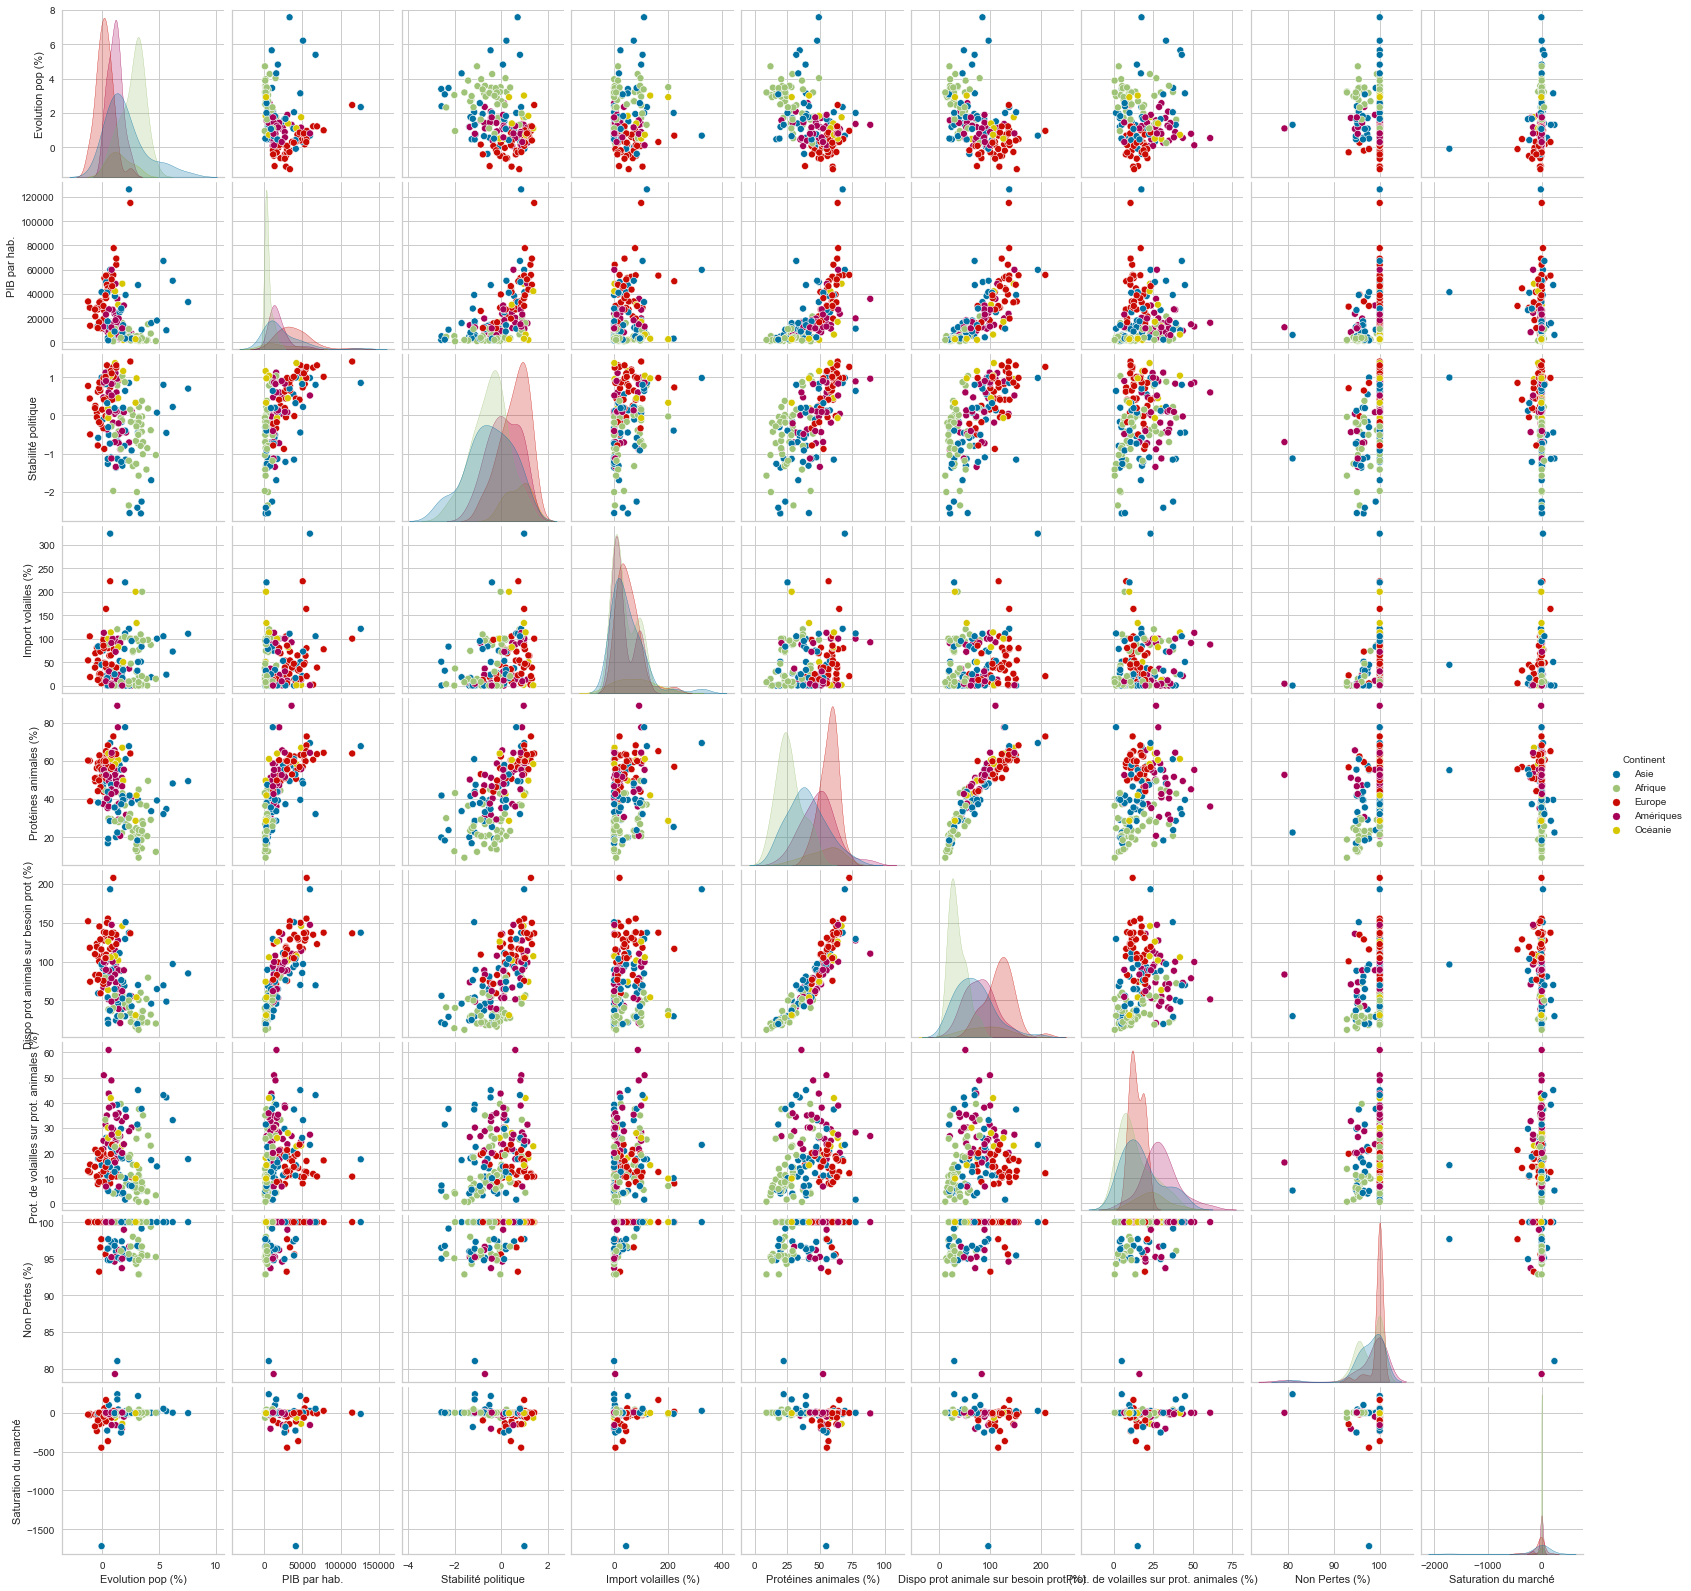

In [67]:
ax=sns.pairplot(main_df.iloc[:,0:10],hue='Continent')

**Observation**<br>
On voit clairement au moins 1 gros outlier dans la **saturation du marché**, et 2 dans les **pertes**.
--------------------

Je recherche les outliers de chaque variable numérique.

In [68]:
outliers=[]
var_name=main_df.columns[1:10]

for i in range (len(var_name)):
    median=np.median(main_df[var_name[i]])

    q1=np.median(main_df[main_df[var_name[i]]<=median][var_name[i]])
    q3=np.median(main_df[main_df[var_name[i]]>median][var_name[i]])
    iqr=q3-q1
    outlier_q1=q1-(1.5*iqr)
    outlier_q3=q3+(1.5*iqr)
    
    outliers.append(main_df[(main_df[var_name[i]]>outlier_q3)|(main_df[var_name[i]]<outlier_q1)][var_name[i]].index.values)

    print(colored((f"Les outliers de la variable {var_name[i]} sont les données inférieures à {round(outlier_q1,2)} et supérieures à {round(outlier_q3,2)}"),'blue', attrs=['bold']))
    
    if (main_df[(main_df[var_name[i]]>outlier_q3)|(main_df[var_name[i]]<outlier_q1)]).size>1:
        print(f"{main_df[(main_df[var_name[i]]>outlier_q3)|(main_df[var_name[i]]<outlier_q1)][var_name[i]]}")
    else:
        print(f"Il n'y a pas d'outliers pour la variable {var_name[i]}.")
    print("_________________________________________________________________________________________________________________________________________________")
    

Les outliers de la variable Evolution pop (%) sont les données inférieures à -2.55 et supérieures à 5.53
Zone
Jordanie    5.64
Koweït      6.20
Oman        7.56
Name: Evolution pop (%), dtype: float64
_________________________________________________________________________________________________________________________________________________
Les outliers de la variable PIB par hab. sont les données inférieures à -31989.15 et supérieures à 66395.25
Zone
Chine - RAS de Macao    126144.0
Irlande                  77749.2
Luxembourg              114986.0
Suisse                   69103.6
Émirats arabes unis      67183.6
Name: PIB par hab., dtype: float64
_________________________________________________________________________________________________________________________________________________
Les outliers de la variable Stabilité politique sont les données inférieures à -2.81 et supérieures à 2.82
Il n'y a pas d'outliers pour la variable Stabilité politique.
_________________________

/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


La variable saturation du marché a beaucoup d'outliers. Je vais supprimer ceux qui sont positifs. Nous ne voulons pas aller sur un marché trop saturé.<br>
Je supprime également les pays avec beaucoup de pertes.

In [69]:
#mask_del_outliers=main_df[(main_df["Saturation du marché"]>53)|(main_df.Pertes>12)]

In [70]:
#main_df.drop(mask_del_outliers.index, inplace=True)

Le Japon ayant une valeur vraiment trop extrême sur la saturation du marché, je supprime cette ligne.

In [71]:
main_df.drop(index="Japon", inplace=True)

J'applatis le fichier outliers qui contient pluseiurs listes.

In [72]:
import itertools
flat_list = itertools.chain(*outliers)

outliers_list=(list(flat_list))# converting iterable to list

J'affiche les pays restants ayant au moins un outlier dans une colonne.

In [73]:
main_df.loc[main_df.index.isin(outliers_list)]

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,,
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0
Arabie saoudite,Asie,3.14,47306.2,-0.45,50.31,39.54,69.76,45.00,100.00,215.0
Australie,Océanie,1.75,48398.5,0.95,1.37,66.94,145.77,22.96,100.00,-143.0
Belgique,Europe,0.68,50442.3,0.73,222.37,56.93,116.33,7.92,100.00,13.0
Bolivie (État plurinational de),Amériques,1.71,8423.7,-0.44,0.23,51.17,70.56,32.66,93.71,-206.0
...,...,...,...,...,...,...,...,...,...,...
Ukraine,Europe,-0.41,11860.6,-0.79,11.99,44.11,76.61,19.95,100.00,-99.0
Égypte,Afrique,2.33,11014.5,-1.19,8.80,25.66,49.80,18.26,100.00,45.0
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0


**Observation**<br>
Malgré la présence d'outliers, je ne souhaite pas supprimer les informations qui ne me semblent pas abérrantes ou anormales lorsqu'on les regarde. Cela fait même partie de l'analyse, les individus avec de fortes valeurs sur certaines variables peuvent être intéressants à envisager et donner du poids à la sélection de ce pays.<br>
Le problème pour le k-means est que les outliers peuvent fausser le découpage en cluster en attirant certaines données vers eux et donc en déplaçant des clusters.
-------------------------

Je créé mon dataframe avec uniquement les valeurs numériques.

In [74]:
main_df_num=main_df.iloc[:,1:10]

## CAH

Classification ascendante hiérarchique : la finalité est de trouver le nombre de cluster idéal. On va "couper" l'arbre pour définir le nombre de classe là où les branches semblent les plus longues.


On met les données à la même échelle pour pouvoir interpréter la heat map avec l'attribut standard_scale, et on ne garde que les données numériques (exit continent)

In [75]:
# Preparing data for clustering
X = main_df_num
names = main_df_num.index
X

,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,
Afghanistan,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0
Afrique du Sud,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0
Albanie,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0
Algérie,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0
Allemagne,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0
Équateur,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0
États-Unis d'Amérique,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0


In [76]:
# Centering and Reduction
scaler = StandardScaler()
XCR = scaler.fit_transform(X)
# Dataframe viz
pd.DataFrame(XCR, columns=X.columns, index=names)

,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,
Afghanistan,1.242418,-0.883583,-2.811795,0.097727,-1.425033,-1.290025,-1.170078,-0.694692,0.231734
Afrique du Sud,0.033985,-0.310146,0.019221,-0.415483,-0.008053,-0.063747,1.805665,-0.837603,0.231734
Albanie,-1.391694,-0.363074,0.165847,0.675739,0.497264,1.176883,-0.720307,0.528764,0.124438
Algérie,0.373432,-0.413295,-1.232742,-0.869676,-0.985493,-0.588704,-0.925768,-1.105996,0.231734
Allemagne,-0.943624,1.595069,1.011768,0.050283,1.080654,1.275160,-0.515708,0.528764,0.996219
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,2.593419,2.280755,0.989210,1.143433,-0.669516,-0.127725,2.107815,0.528764,0.915747
Équateur,0.122241,-0.419101,-0.375542,-0.883563,0.228622,-0.308954,0.123123,-1.210565,0.258558
États-Unis d'Amérique,-0.509131,1.927575,0.673400,-0.870641,1.308723,1.765574,0.750731,0.528764,-1.900776


Je vérifie que les données sont bien proche de 0 pour la moyenne, et égales à 1 pour l'écart-type (action du centrage réduction)

In [77]:
mean_and_standard_deviation_info(XCR)

Moyennes:
-1.8102255759831612e-16

Ecart-type :
1.0



Choix théorique de la meilleure liaison de clustering pour la CAH, , grâce au concept de coefficient cophénétique.<br>
Plus le coefficient est proche de 1, mieux le clustering préserve les distances d'origine.

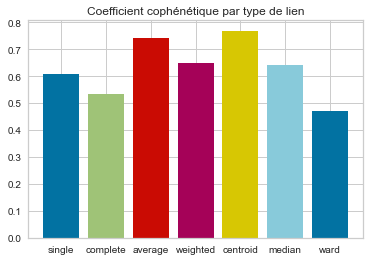

La meilleure méthode théorique de lien est la 'centroid'.


In [78]:
best_linkage_ach(XCR)

Le découpage de la classification hiérarchique se fait après la 1re visualisation du dendrogramme.<br>
En principe, on coupe vers le haut, là où les branches sont les plus longues. <br>
La méthode de ward, qui ne présente pas le meilleur coefficient cophénéitique ici, sera privilégie car donnant de meilleurs résultats de découpage : il minimise l'inertie intra-classe que ne prennent pas en compte les autres méthodes (uniquement la distance), ce qui permet d'avoir des clusters homogènes.

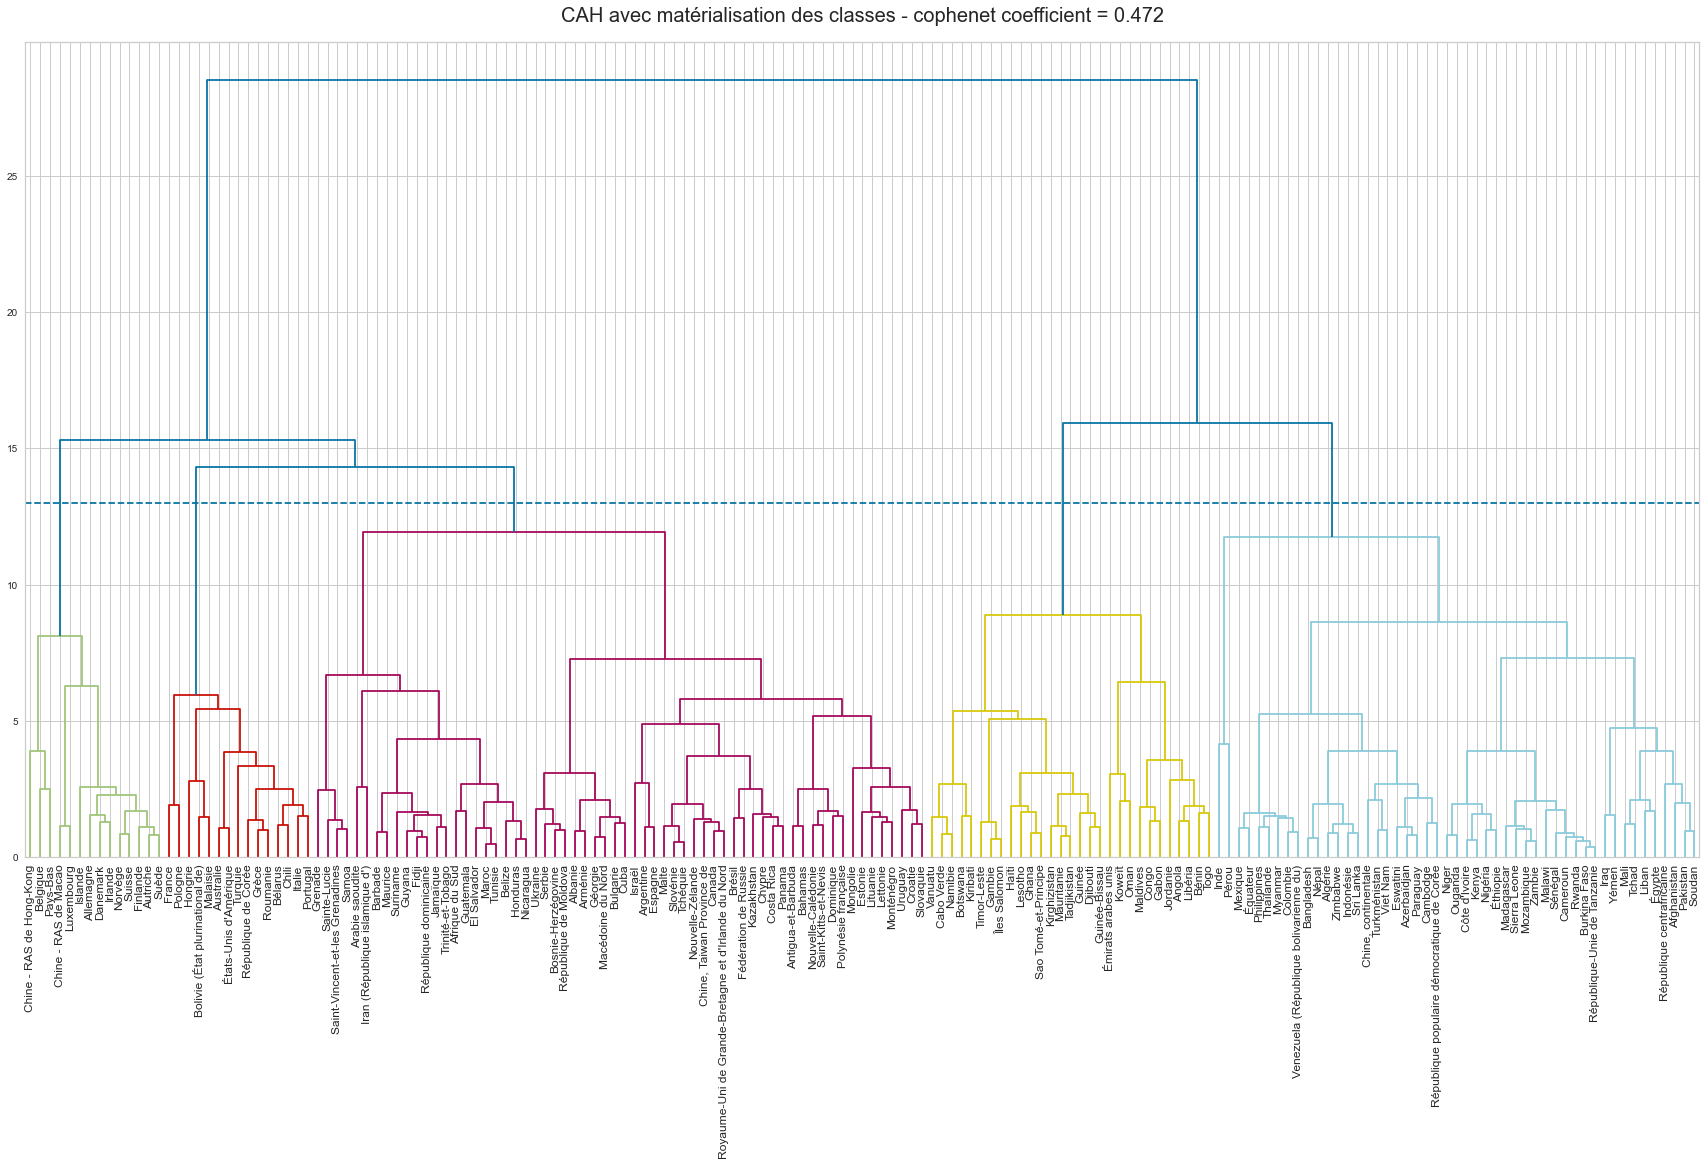

In [79]:
Z = linkage(XCR, method="ward",metric="euclidean")
plot_dendrogram(XCR,Z,13)

### Analyse

In [80]:
number_of_clusters=5# Clusters are colored on the dendogram below
CAH_groups = fcluster(Z, number_of_clusters, criterion='maxclust') # ou fcluster(Z, threshold, criterion='distance')

display_countries_from_clusters(number_of_clusters, CAH_groups)

Affichage des 5 clusters

Cluster 1 :
Allemagne, Autriche, Belgique, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Danemark, Finlande, Irlande, Islande, Luxembourg, Norvège, Pays-Bas, Suisse, Suède
 
Cluster 2 :
Australie, Bolivie (État plurinational de), Bélarus, Chili, France, Grèce, Hongrie, Italie, Malaisie, Pologne, Portugal, Roumanie, République de Corée, Turquie, États-Unis d'Amérique
 
Cluster 3 :
Afrique du Sud, Albanie, Antigua-et-Barbuda, Arabie saoudite, Argentine, Arménie, Bahamas, Barbade, Belize, Bosnie-Herzégovine, Brésil, Bulgarie, Canada, Chine, Taiwan Province de, Chypre, Costa Rica, Croatie, Cuba, Dominique, El Salvador, Espagne, Estonie, Fidji, Fédération de Russie, Grenade, Guatemala, Guyana, Géorgie, Honduras, Iran (République islamique d'), Israël, Jamaïque, Kazakhstan, Lettonie, Lituanie, Macédoine du Nord, Malte, Maroc, Maurice, Mongolie, Monténégro, Nicaragua, Nouvelle-Calédonie, Nouvelle-Zélande, Panama, Polynésie française, Royaume-Uni de Grande-Bretagne 

<u>Top 5 pays végétariens</u><br>
- L’Inde : 39 % de végétariens en 2021 (groupe 5)<br>
- Le Mexique : 20 % (2018) (groupe 5)<br>
- Le Brésil : 14 % de végétariens et véganes (2018) (groupe 3)<br>
- Taïwan et Israël : 13 %, végétariens et véganes confondus (2019 et 2015) (groupes 3)<br>
    
<u> Top 5 des pays les plus consommateurs de viande - Par kg de viande par personne par an</u>
- USA – 120kg (groupe 2)
- Koweït – 119.2kg (groupe 4)
- Australie – 111.5kg (groupe 2)
- Les Bahamas – 109.5kg (groupe 3)
- Luxembourg – 107.9kg (groupe 1)

<u> Top 5 des pays les moins consommateurs de viande - Par kg de viande par personne par an</u>
- Bangladesh - 4kg (groupe 5)
- Inde - 4.4kg (groupe 5)
- Burundi - 5.2kg
- Sri Lanka - 6.3kg (groupe 5)
- Rwanda - 6.5kg

Je créé un dataframe avec l'information de continent et de clusters pour voir la répartition géographique

In [81]:
# Characterization of clusters according to the continent
continent_distrib = pd.DataFrame({"Continent":main_df.Continent,"Cluster": CAH_groups })
print("Affichage du tableau de contingence")
continent_distrib.pivot_table(index="Continent", columns="Cluster", aggfunc=len, fill_value=0, margins=True)

Affichage du tableau de contingence


Cluster,1,2,3,4,5,All
Continent,,,,,,
Afrique,0,0,4,17,24,45
Amériques,0,3,25,1,6,35
Asie,2,3,9,8,19,41
Europe,12,8,19,0,0,39
Océanie,0,1,5,3,0,9
All,14,15,62,29,49,169


Affectation des clusters pour chaque individu adns le dataframe principal

In [82]:
print("Affichage du cluster pour chaque individu")
#CAH_groups = fcluster(Z, threshold, criterion='distance') # second method to do it. For 1st one, see "clusters" below when you know the number of clusters.
main_df['CAH'] = CAH_groups
main_df

Affichage du cluster pour chaque individu


,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH
Zone,,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0,5
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0,3
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0,3
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0,5
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0,1
...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0,4
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0,5
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0,2


On compare maintenant chaque groupe d'individus par rapports à nos variables

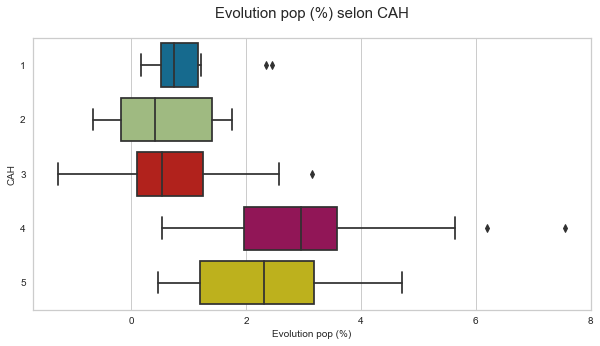

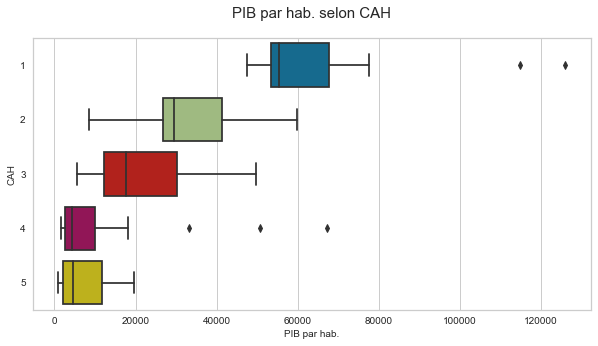

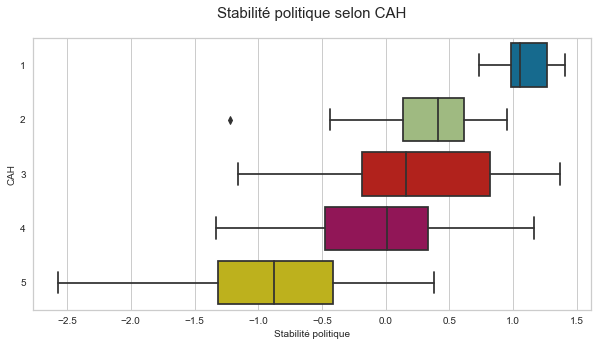

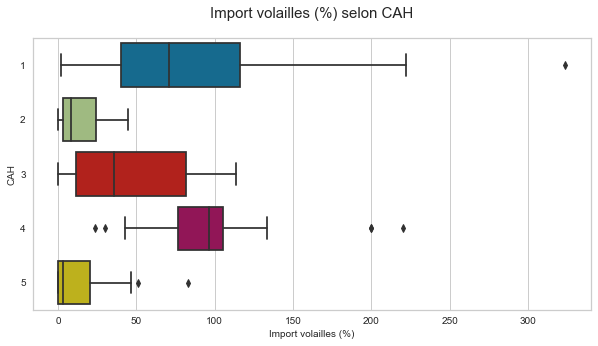

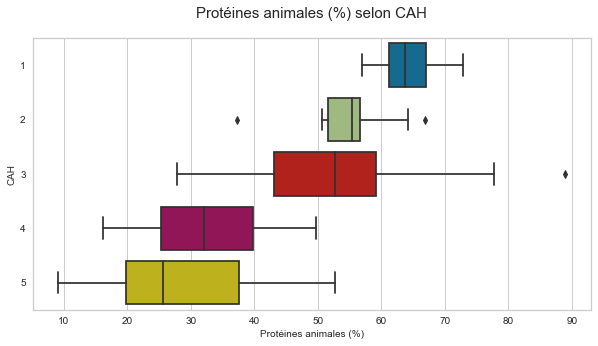

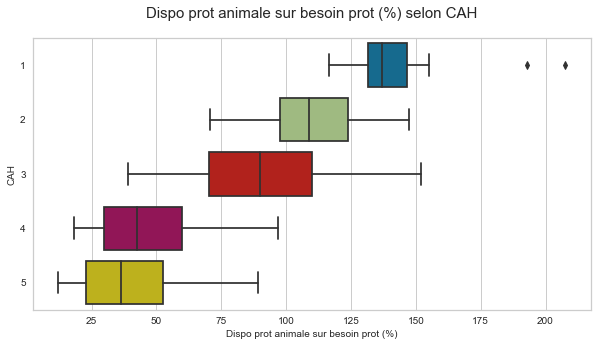

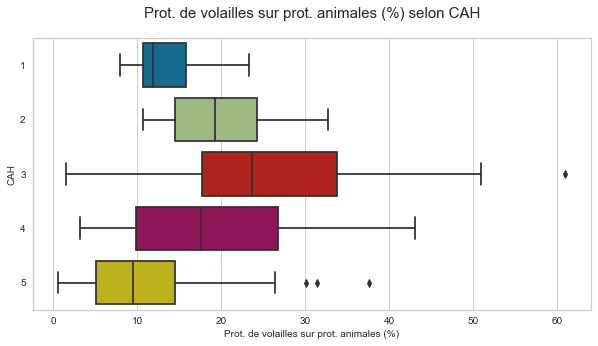

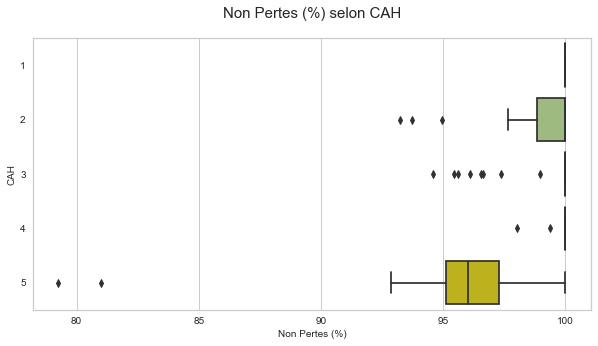

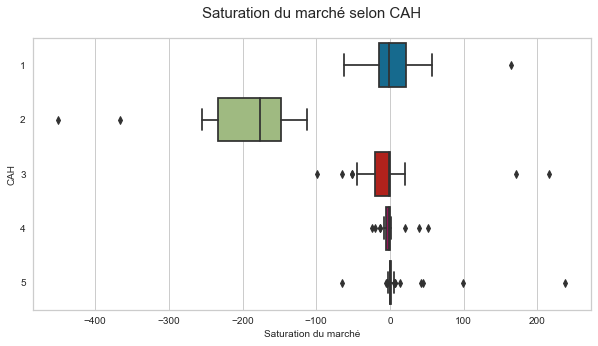

In [83]:
for item in main_df.columns[1:len(main_df.columns)-1]:
    build_plot(main_df,item, "CAH")

Visualisation sur une heatmap par groupe

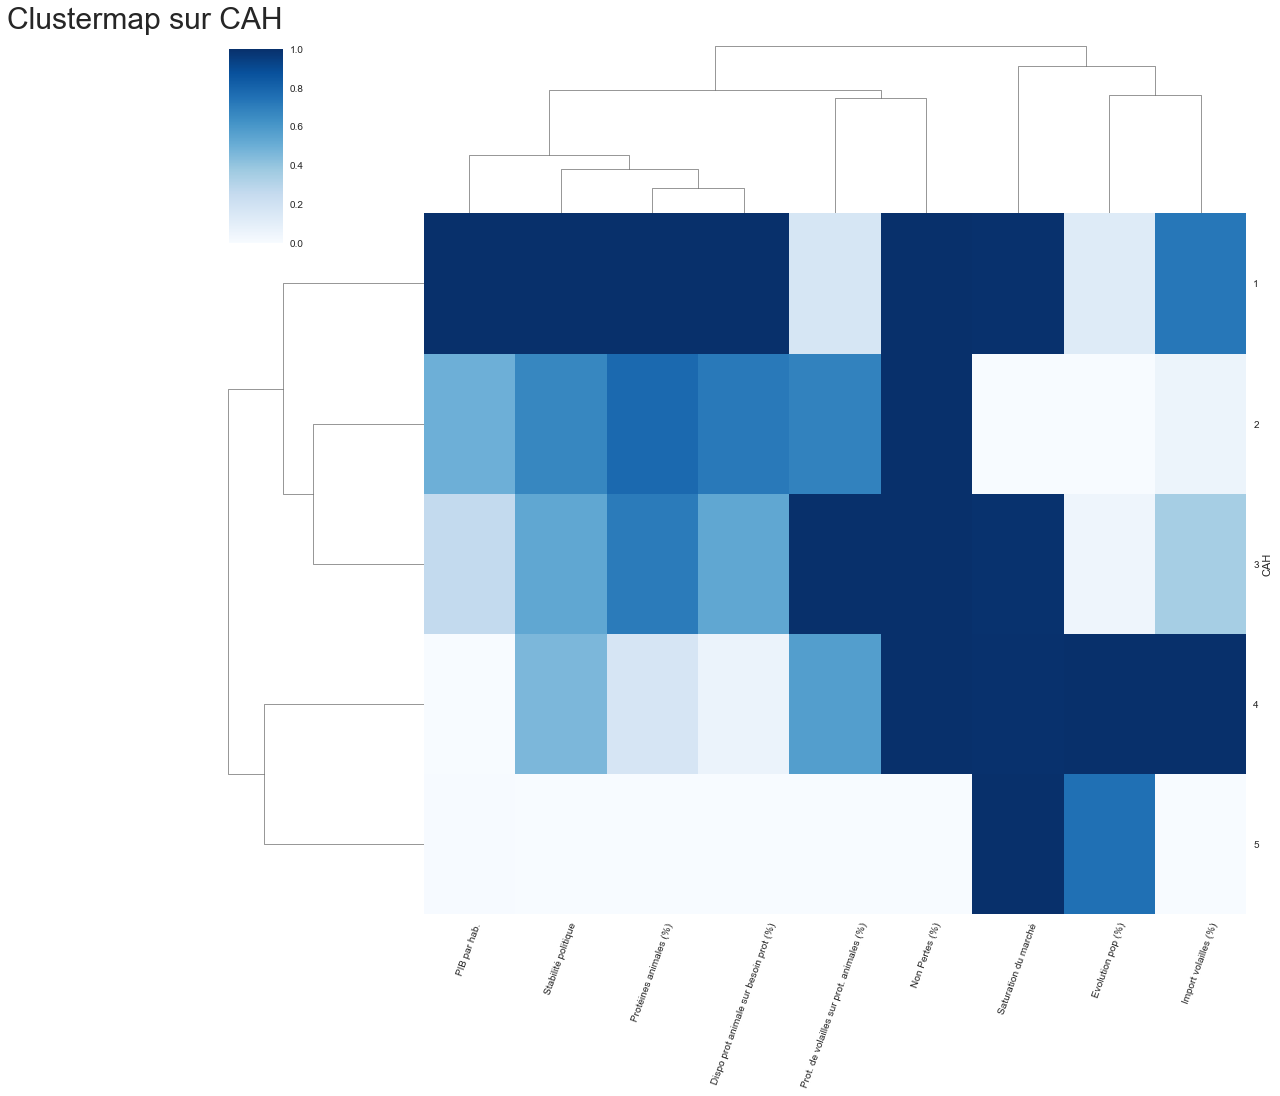

In [84]:
clustermap_CAH=main_df.iloc[:,1:11]
build_clustermap(clustermap_CAH,"CAH")

**CAH par variables :<br>**
- Le taux annuel de la **croissance démographique** de la population mondiale est de 1,2 % ([source](https://fr.wikipedia.org/wiki/Population_mondiale#cite_note-prb2016-1)). Les groupes 4 et 5 ont le plus fort taux d'augmenation annuel de leur population en 10 ans. 

- Le **PIB** moyen en dollars PAA (Parité du Pouvoir d'Achat) en 2017 est de ~16 000 dollars. Les groupes 1 et 2 se démarquent sur cet indicateur.

- Le groupe 5 est à envisager avec précaution si on ne veut pas s'aventurer dans des pays dont le commerce des affaires, lié à la **stabilité politique**, n'est pas probant. Le groupe 1 est le plus stable avec aucune valeur négative.

- Le groupe 1 a le plus recours à l'**importation** pour la volaille.  Il serait plus pertinent de se diriger vers des pays important peu et donc avec moins de concurrence : alors les groupes 2 et 5 s'illustrent.

- La **disponibilité de protéines animales** et la **Dispo prot animale sur besoin prot (%)** ont les mêmes tendances : plus élevéeq chez les groupes 1 et 2, et la plus basse dans le groupe 5. Le groupe 5 contient l'Inde et le Mexique qui mangent peu de viande et avec a une populaiton très élevée pour l'Inde, ce qui explique les résultats tirés vers le bas.<br>
    
- Parmi les protéines animales disponibles, c'est dans les groupes 3 et 4 que la part de **protéines de volailles** est la plus élevée. Ce qui laisse une marge de progression sur les autres groupes.

- Le groupe 2 concentre la plupart des pays dont le **marché est saturé** et avec beaucoup de **pertes**. On évitera les pays de ce groupe.

- Le groupe 5 a énormément de **pertes** par rapport aux pays des autres groupes, dont les outliers visibles, Pérou et Inde. Le groupe 2 est aussi visible sur cette variable, même si c'est moins prononcé. 


**Le groupe 1 est le plus équilibré sur l'ensemble des variables**. C'est un groupe riche, qui mange de la protéine animale, qui a une marge de progression sur la part de volaille, mais qui importe beaucoup par rapport aux autres.<br>
**On déconseillera le groupe 5 qui est plus végétarien que les autres et qui enregistre beaucoup de perte sur la volaille, et le groupe 2 dont le marché est saturé, bien que les autres indicateurs soient corrects.**<br>
**Le groupes 3 et 4 sont aussi des choix intéressants** et consomment déjà pas mal de volaille. **On se dirigera plutôt vers le 4** qui a une bonne marge de progression sur la viande de volaille.<br>


In [85]:
main_df

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH
Zone,,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0,5
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0,3
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0,3
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0,5
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0,1
...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0,4
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0,5
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0,2


**Conclusion CAH :<br>**
- Le taux annuel de la **croissance démographique** de la population mondiale est de 1,2 % ([source](https://fr.wikipedia.org/wiki/Population_mondiale#cite_note-prb2016-1)). Le groupe 1 a le plus fort taux d'augmenation annuel de sa population en 10 ans. Les groupes 2 et 3 sont aussi intéressants.
- Le **PIB** moyen en dollars PAA (Parité du Pouvoir d'Achat) en 2017 est de ~16 000 dollars. Les groupes 1 et 6 se démarquent sur cet indicateur.
- Les groupes 3 et 4 sont à envisager avec précaution si on ne veut pas s'aventurer dans des pays dont le commerce des affaires, lié à la **stabilité politique**, n'est pas probant. Les groupes 5 et 6 n'ont aucune valeur négative.
- Le groupe 2 a le plus recours à l'**importation** pour la volaille. On relève aussi la présence du groupe 1, et dans une moindre mesure du 6.
- La **disponibilité de protéines animales** est la plus élevée chez les groupes 5 et 6, et la plus basse dans les groupes 2 et 3. Le groupe 3 contient l'Inde qui mange peu de viande et qui a une populaiton très élevée.<br>
    <u>Top 5 pays végétariens</u><br>
    - L’Inde : 39 % de végétariens en 2021 (groupe 4)<br>
    - Le Mexique : 20 % (2018) (groupe 5)<br>
    - Le Brésil : 14 % de végétariens et véganes (2018) (groupe 5)<br>
    - Taïwan et Israël : 13 %, végétariens et véganes confondus (2019 et 2015) (respectivement groupes 2 et 5)<br>
- Parmi les protéines animales disponibles, c'est dans les groupes 1, 5 que la part de **protéines de volailles** est la plus élevée.
- Enfin, les pays des groupes 1 et 5 ont la plus grande quantité d'énergie fournie par la volaille.

**Le groupe 1, composé de seulement 5 pays, semble être le meilleur choix. <br>
Il vaut mieux éviter le groupe contenant des pays consommant le moins de viande, on excluera donc les pays du groupe 3 (malgré les 2 outliers).<br>
Si on veut voir un peu plus grand, les groupes 5 et 6 seraient également une bonne option, L'import sur le groupe 5 semble limité (auto-suffisance en production volaille?). Ca peut être un problème ou un avantage si on y voit qu'il y a peu de concurrence dans l'import.<br>
En regardant le tableau de contingence, le groupe 1 est exclusivement situé en Asie (et plus particulièrement au Moyen-Orient, plus précisément dans le golfe Persique).<br>
Les pays du groupe 5 sont majoritairement situés en Amériques, et ceux du groupe 6 en Europe.**

## K-means : Paritionnement direct

La CAH n'est pas optimale car on prend en compte une hiérarchie entre les individus. On va tester une autre méthode de clustering pour comparer les résultat.

### Méthode du coude

Pour déterminer le nombre optimal de clusters par la méthode du coude, il faut sélectionner la valeur de k au «coude» du graphique généré, c’est-à-dire le point après lequel la distorsion / inertie commence à diminuer de façon + linéaire.<br>

<u>Distorsion</u> : Elle est calculée comme la moyenne des distances au carré des centres de cluster des clusters respectifs. En règle générale, la métrique de distance euclidienne est utilisée.<br>
<u>Inertie</u> : C’est la somme des distances au carré des échantillons par rapport à leur centre de cluster le plus proche.

J'itère les valeurs de k de 1 à 10 et calcule les valeurs de la distorsion et l’inertie pour chaque valeur de k dans la plage donnée.

In [86]:
X

,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,
Afghanistan,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0
Afrique du Sud,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0
Albanie,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0
Algérie,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0
Allemagne,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0
Équateur,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0
États-Unis d'Amérique,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0


In [87]:
# Je repars de mon df X qui ne contient que les variables numériques et pas la colonne CAH

mean_and_standard_deviation_info(X)

Moyennes:
Evolution pop (%)                                1.559941
PIB par hab.                                 20243.414201
Stabilité politique                             -0.077041
Import volailles (%)                            45.812840
Protéines animales (%)                          42.961006
Dispo prot animale sur besoin prot (%)          74.600533
Prot. de volailles sur prot. animales (%)       18.603787
Non Pertes (%)                                  98.483018
Saturation du marché                           -17.278107
dtype: float64

Ecart-type :
Evolution pop (%)                                1.477359
PIB par hab.                                 20642.143141
Stabilité politique                              0.889242
Import volailles (%)                            52.004228
Protéines animales (%)                          16.315337
Dispo prot animale sur besoin prot (%)          41.230310
Prot. de volailles sur prot. animales (%)       11.618085
Non Pertes (%)                   

Je centre et réduis manuellement (pour essayer une autre technique) : je retranche la moyenne au dataframe et je divise par l'écart-type.<br>
J'affiche ensuite le résultat. Si la moyenne vaut 0 (ou presque) et l'écart-type 1, c'est ok.

In [88]:
XCR_km=(X - X.mean())/X.std()
#X_CR_km=(X.sub(X.mean())).div(X.std()) -> autre méthode
mean_and_standard_deviation_info(XCR_km)

Moyennes:
Evolution pop (%)                            4.519725e-16
PIB par hab.                                 4.204395e-17
Stabilité politique                          9.854051e-18
Import volailles (%)                         2.890521e-16
Protéines animales (%)                       1.845992e-16
Dispo prot animale sur besoin prot (%)      -6.464257e-16
Prot. de volailles sur prot. animales (%)   -4.125562e-16
Non Pertes (%)                               3.134902e-15
Saturation du marché                        -2.726287e-17
dtype: float64

Ecart-type :
Evolution pop (%)                            1.0
PIB par hab.                                 1.0
Stabilité politique                          1.0
Import volailles (%)                         1.0
Protéines animales (%)                       1.0
Dispo prot animale sur besoin prot (%)       1.0
Prot. de volailles sur prot. animales (%)    1.0
Non Pertes (%)                               1.0
Saturation du marché                         1.

In [89]:
#distortions = [] 
inertias = [] 

K = range(1,10) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k,n_init=10, init='k-means++',random_state=0)
    kmeanModel = kmeanModel.fit(XCR_km)
    #distortions.append(sum(np.min(cdist(X_CR_km, kmeanModel.cluster_centers_,'euclidean'),axis=1)) / X_CR_km.shape[0]) 
    inertias.append(kmeanModel.inertia_)   

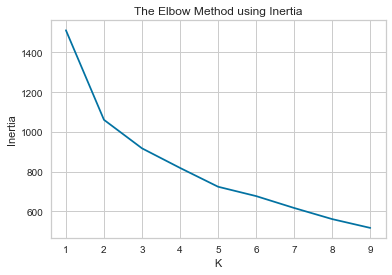

Valeurs d'inertie :
[1512.0000000000005, 1061.005291370179, 917.4164499681533, 818.7428764451831, 724.0387060924211, 676.8969409460392, 617.0289395482349, 561.0092953993511, 516.715771483158]



In [90]:
plt.plot(K, inertias, 'bx-') #plt.plot(K, distortions, 'bx-') 
plt.xlabel('K') 
plt.ylabel('Inertia') #plt.ylabel('Distortion') 
plt.xticks(np.arange(1,10, step=1))
plt.title('The Elbow Method using Inertia') #plt.title('The Elbow Method using Distortion') 
plt.show() 

print (f"""Valeurs d'inertie :
{inertias}
""")

**Observation**<br>
Le graphique nous montre a priori un "coude" sur la valeur 2. <br>
-------------------

On regarde pour 2 clusters

In [91]:
result = KMeans(n_clusters=2, n_init=10, init='k-means++',random_state=0)
result.fit(XCR_km)

KMeans(n_clusters=2, random_state=0)

On affiche les centres de classes. 

In [92]:
pd.DataFrame(result.cluster_centers_)

,0,1,2,3,4,5,6,7,8
0,-0.549122,0.617500,0.686666,0.166356,0.790197,0.784685,0.250310,0.379662,-0.267229
1,0.542662,-0.610235,-0.678588,-0.164399,-0.780900,-0.775453,-0.247365,-0.375196,0.264085


On affiche les valeurs des clusters

J'ajoute le clustering dans le dataframe copié. A SUPPRIMER

### Méthode de visualisation du coude - kelbow_visualizer
On va tester avec un visualiseur "automatique" de coude pour voir ce qui est préconisé comme découpage.

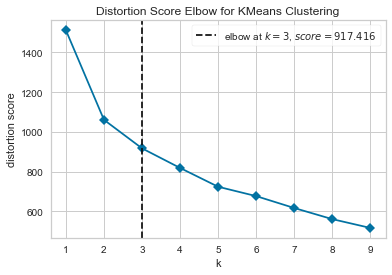

In [93]:
elbow = kelbow_visualizer(result, X=XCR_km, k=(1,10), metric='distortion', timings=False)

#ou 

#from yellowbrick.cluster import KElbowVisualizer

#elbow = KElbowVisualizer(result,k=(1,10), metric='distortion', timings=False)
#elbow.fit(X_CR_km) # Fit the data to the visualizer
#elbow.show()

**Observation**<br>
3 clusters étant le nombre défini, on va faire le test sur 3 clusters.
------------

In [94]:
result_3k = KMeans(n_clusters=3, n_init=10, init='k-means++',random_state=0)
result_3k.fit(XCR_km)

KMeans(n_clusters=3, random_state=0)

### Méthode de l'analyse du coefficient de silhouette

Je regarde si l'analyse des silhouettes donne le même résultat.

Calcul des scores de silhouette pour le modèle de clustering K-means avec différentes valeurs pour le nombre de clusters.

Quand le nombre de clusters vaut 2, le score de silhouette score vaut 0.272.
Quand le nombre de clusters vaut 3, le score de silhouette score vaut 0.205.
Quand le nombre de clusters vaut 4, le score de silhouette score vaut 0.202.
Quand le nombre de clusters vaut 5, le score de silhouette score vaut 0.222.
Quand le nombre de clusters vaut 6, le score de silhouette score vaut 0.199.
Quand le nombre de clusters vaut 7, le score de silhouette score vaut 0.213.
Quand le nombre de clusters vaut 8, le score de silhouette score vaut 0.210.
Quand le nombre de clusters vaut 9, le score de silhouette score vaut 0.213.


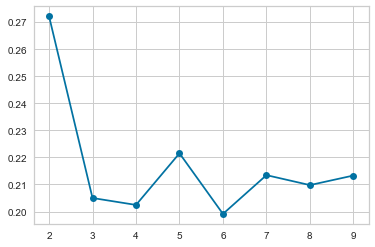

In [95]:
#Use silhouette score
silhouettes=[]
for n_clusters in range(2,10):
    result = KMeans(n_clusters=n_clusters,n_init=10, init='k-means++',random_state=0) # Instantiate the Kmeans model with 10 times a random init
    result.fit(XCR_km) # Fit the KMeans model on normalized data
    #centers = result.cluster_centers_
    score = silhouette_score(XCR_km, result.labels_, metric='euclidean') #Calculate Silhoutte coefficient Score 
    silhouettes.append(score)
    
    print(f"Quand le nombre de clusters vaut {n_clusters}, le score de silhouette score vaut {score:.3f}.")  

plt.plot(range(2,10),silhouettes, marker='o') 
plt.show()

Il faut privilégier 2 ou 3 clusters pour lesquels le score est le + élevé. 

Seconde méthode automatisée pour l'indentification du coude avec la librairie dédiée.

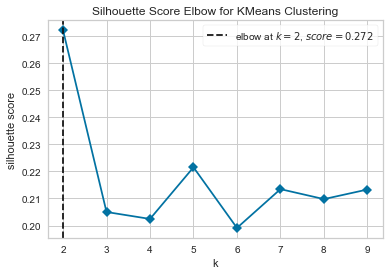

In [96]:
visualizer = kelbow_visualizer(result,X=XCR_km, k=(2,10),metric='silhouette', timings= False)

La technique 2 montre un clustering de 2.

### Méthode de l'analyse des silhouettes

Analyse des silhouettes avec k de 2 à 8

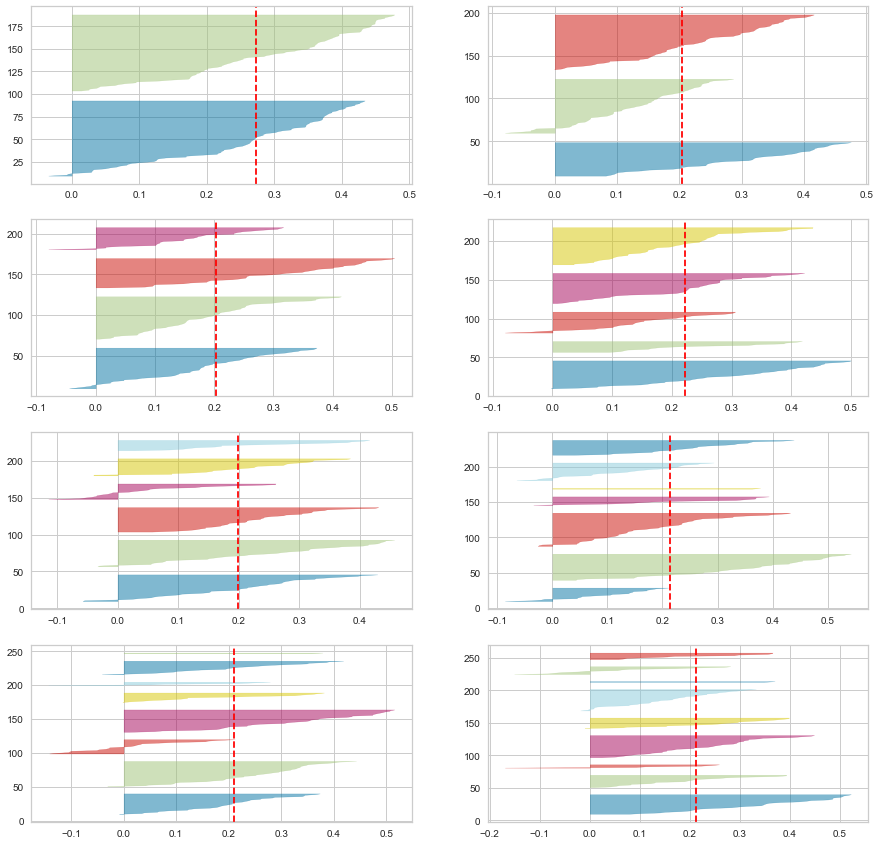

In [97]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in range (2,10):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(XCR_km)

**Observation**<br>

Les groupes 7 et 8 ont un score de silhouette inférieur à la moyenne.<br>

Pour une valeur de 5 à 9 clusters, l'épaisseur de chaque cluster varie trop. Tout comme la taille (longueur) pour les clusters 3 à 9.<br>

Une valeur de 2 pour le nombre de clusters semble optimale. Le score de chaque silhouette est au dessus de la moyenne des scores et la fluctuation à peu près similaires, tout comme l'épaisseur de chaque cluster.
________________________

**Conclusion<br>
Les différentes méthodes de partitionnement direct s'accordent pour le nombre de clusters idéal : 2 ou 3.<br>
Le k-means étant sensible aux outliers, les résultats peuvent être biaisés.**

### Analyse

Ajout du résultat du clustering kmeans dans le tableau principal.

In [98]:
main_df['Kmeans']=result_3k.labels_+1
main_df

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans
Zone,,,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0,5,1
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0,3,2
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0,3,3
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0,5,1
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0,4,2
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0,5,1
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0,2,3


In [99]:
num_clusters=len(main_df.Kmeans.unique())
print(f"Affichage des {num_clusters} clusters")
print("")
for i in range(1,num_clusters+1):
    print(f"Cluster {i} :")
    print(f", ".join(main_df.index[main_df.Kmeans == i].sort_values()))
    print(" ")

Affichage des 3 clusters

Cluster 1 :
Afghanistan, Algérie, Bangladesh, Burkina Faso, Cambodge, Cameroun, Chine, continentale, Côte d'Ivoire, Guinée, Inde, Indonésie, Kenya, Liban, Madagascar, Malawi, Mali, Mozambique, Niger, Nigéria, Népal, Ouganda, Pakistan, Philippines, Pérou, Rwanda, République centrafricaine, République populaire démocratique de Corée, République-Unie de Tanzanie, Sierra Leone, Soudan, Sri Lanka, Sénégal, Tchad, Thaïlande, Turkménistan, Yémen, Zambie, Zimbabwe, Équateur, Éthiopie
 
Cluster 2 :
Afrique du Sud, Angola, Arabie saoudite, Arménie, Azerbaïdjan, Belize, Bolivie (État plurinational de), Bosnie-Herzégovine, Botswana, Bénin, Cabo Verde, Colombie, Congo, Cuba, Djibouti, El Salvador, Eswatini, Fidji, Gabon, Gambie, Ghana, Grenade, Guatemala, Guinée-Bissau, Guyana, Géorgie, Haïti, Honduras, Iran (République islamique d'), Iraq, Jamaïque, Jordanie, Kirghizistan, Kiribati, Koweït, Lesotho, Libéria, Macédoine du Nord, Maldives, Maroc, Mauritanie, Mexique, Myanmar

In [100]:
# Characterization of clusters according to the continent
continent_distrib_kmeans = pd.DataFrame({"Continent":main_df.Continent,"Cluster": main_df.Kmeans})
print("Affichage du tableau de contingence")
continent_distrib_kmeans.pivot_table(index="Continent", columns="Cluster", aggfunc=len, fill_value=0, margins=True)

Affichage du tableau de contingence


Cluster,1,2,3,All
Continent,,,,
Afrique,23,21,1,45
Amériques,2,18,15,35
Asie,15,17,9,41
Europe,0,4,35,39
Océanie,0,4,5,9
All,40,64,65,169


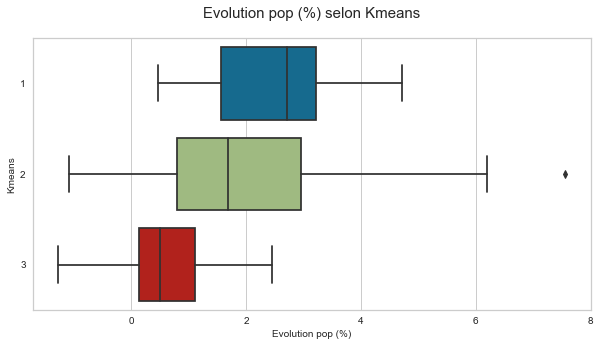

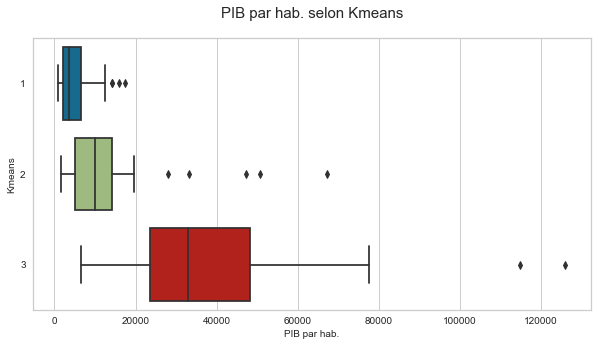

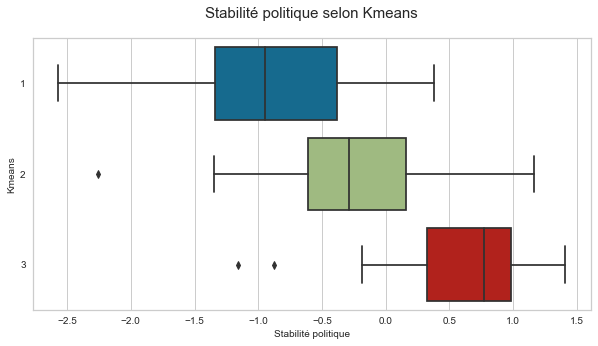

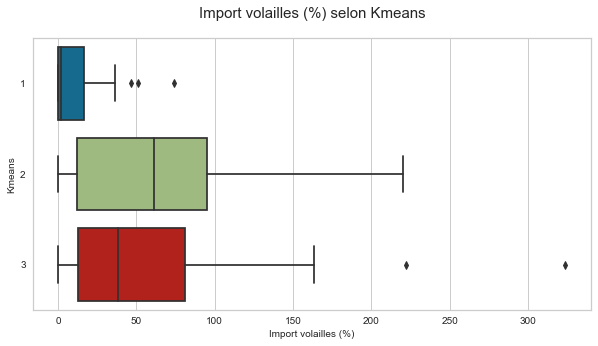

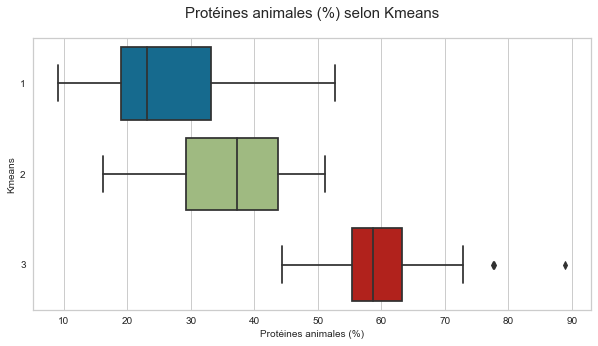

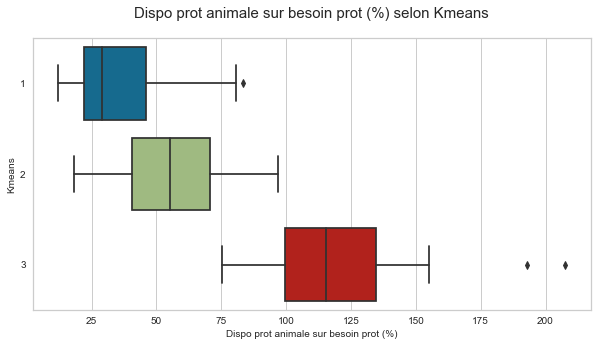

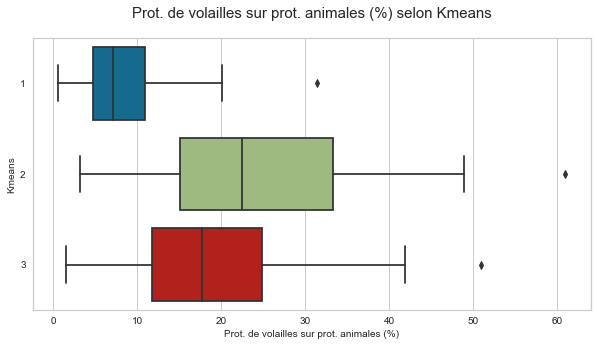

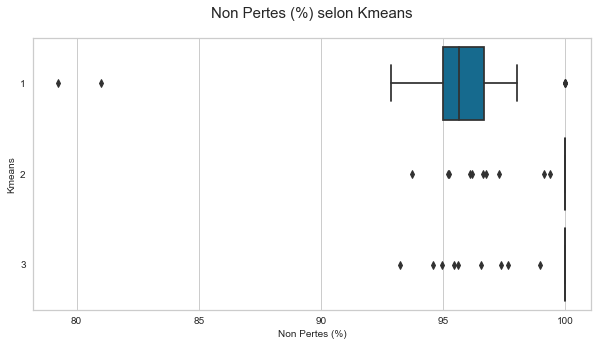

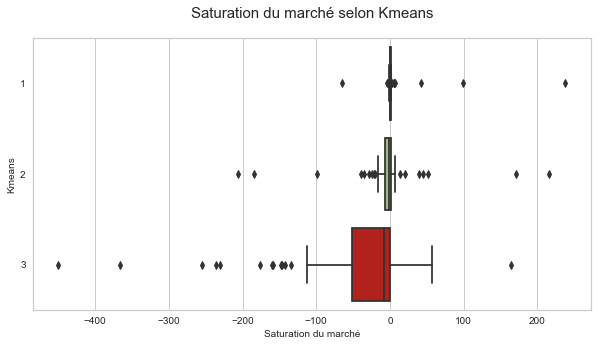

In [101]:
for item in main_df.columns[1:len(main_df.columns)-2]:
    build_plot(main_df,item, "Kmeans")

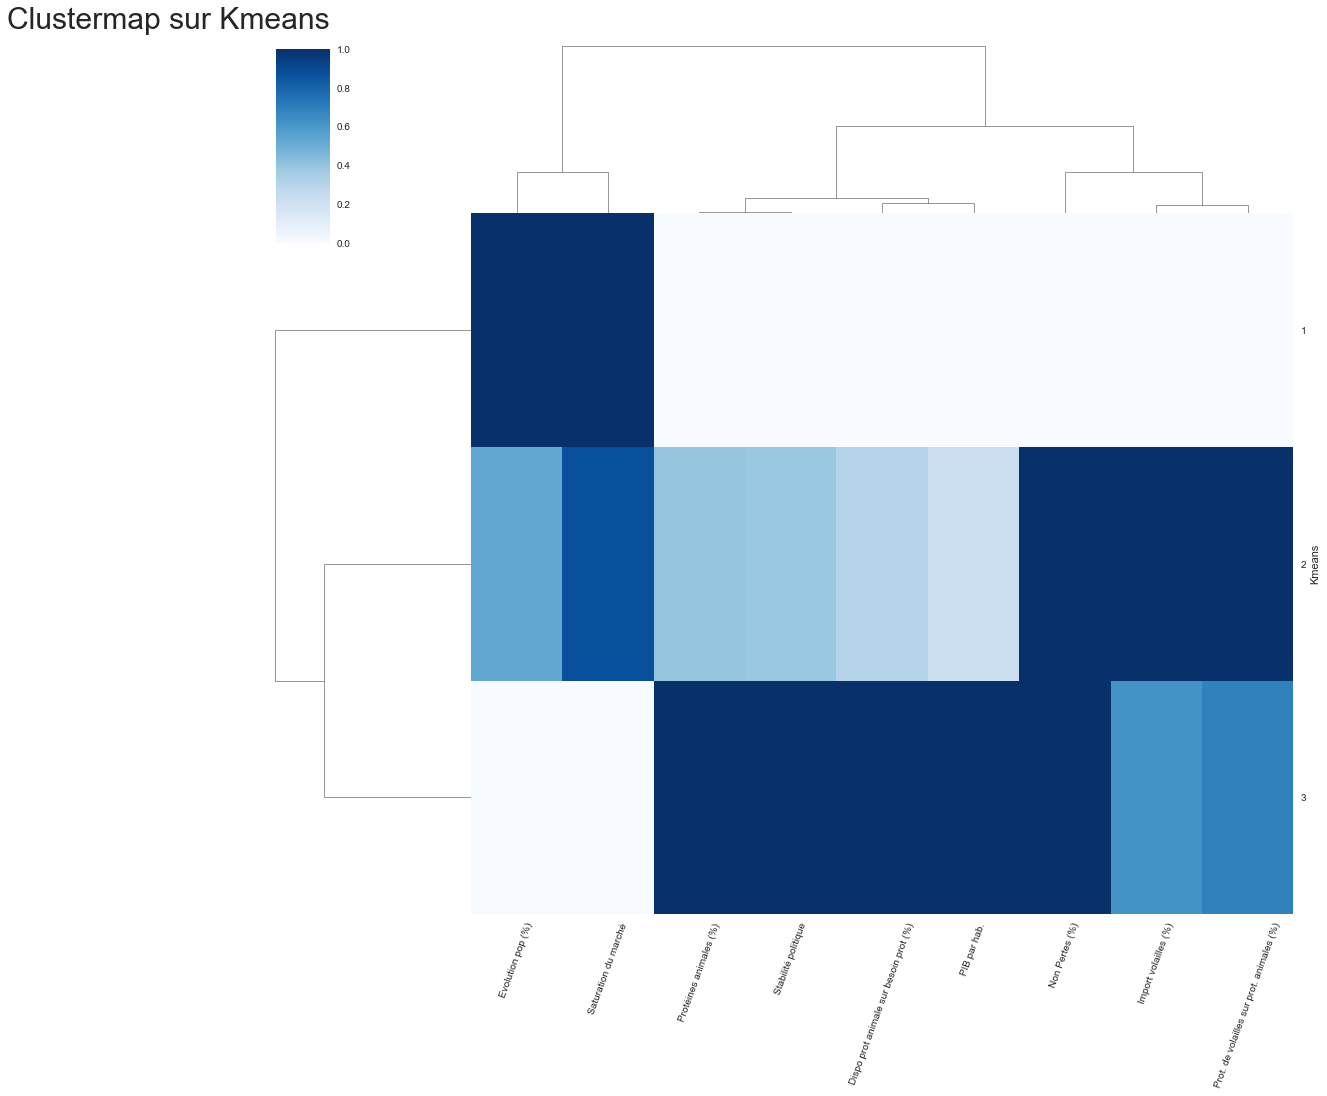

In [102]:
clustermap_kmeans=main_df[main_df.columns.difference(['Continent','CAH'])]
build_clustermap(clustermap_kmeans,'Kmeans')

**Observation<br>**
 - Evolution population : 
     +  groupes 1,2
     -  groupe 3
 - PIB par hab. 
      +  groupes 3,2
      -  groupe 1
 - Stabilité politique
      +  groupes 3,2
      -  groupe 1
 - Import volaille
      +  groupes 1,3
      -  groupe 2
 - Part de protéines animales
      +  groupes 3,2
      -  groupe 1
 - Dispo protéines animales sur besoins
      + groupes 3,2 
      - groupe 2
 - Protéines de volailles (sur prot. animales)
      +  groupe 2,3
      -  groupe 1
 - Saturation du marché
      +  groupes 1,2
      -  groupe 3
 - Pertes
      + groupes 2,3
      -  groupe 1<br>
      
**Le groupe 3**, très visible sur la saturation de marché **devrait être éliminé** ; il y a de fortes chances que les outliers se soient groupés ensemble.<br>
**Le groupe 1** étant le moins carnivore, le moins riche et le moins stable, mais gaspillant le plus, **sera également écarté.**<br>
**On sélectionnerait donc les pays du groupe 2.**

## Comparaison des résultats entre Kmeans et CAH

Comparaison clustering avec :
- 3 clusters kmeans
- 5 clusters CAH



In [103]:
clusters_df=main_df.iloc[:,10:12].copy() #9:11

In [104]:
print("Nombre de pays par cluster selon les méthodes de partitionnement")
clusters_df.pivot_table(index="CAH", columns=["Kmeans"], aggfunc=len, fill_value=0, margins=True)

Nombre de pays par cluster selon les méthodes de partitionnement


Kmeans,1,2,3,All
CAH,,,,
1,0,0,14,14
2,0,2,13,15
3,0,24,38,62
4,1,28,0,29
5,39,10,0,49
All,40,64,65,169


Le groupe 2 a été désigné pour la méthode des kmeans, et les groupes 1 (en premier) et 4 pour les CAH. <br>
On pourrait proposer les 28 pays en commun, qui se retrouvent exclusivement dans le CAH = 4 et kmeans = 2. Aucun ne se retrouve dans notre proposition 1 de CAH, car les outliers de la saturation du marché ont dû absorber les autres pays d'Europe.<br>
La méthode des k-means, qui définit moins de clusters propose moins de granularité dans les résultats.<br>

**Choix 1 = 28 pays en commun des 2 méthodes**

In [105]:
final_choice_prop1=main_df[(main_df.CAH==4)&(main_df.Kmeans==2)]
final_choice_prop1

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans
Zone,,,,,,,,,,,,
Angola,Afrique,4.26,7310.9,-0.39,86.83,29.03,31.65,22.93,99.37,0.0,4,2
Botswana,Afrique,1.76,15948.0,1.03,42.86,43.02,56.45,4.25,100.00,-1.0,4,2
Bénin,Afrique,3.22,3044.5,0.22,76.40,20.64,26.81,37.44,100.00,40.0,4,2
Cabo Verde,Afrique,1.31,6643.2,0.78,120.00,37.07,51.81,25.37,100.00,-8.0,4,2
Congo,Afrique,3.19,4234.7,-0.48,94.55,44.94,50.40,29.80,100.00,-1.0,4,2
Djibouti,Afrique,1.72,4905.0,-0.13,100.00,22.13,29.64,6.26,100.00,0.0,4,2
Gabon,Afrique,4.02,15006.8,0.18,97.44,49.55,79.23,26.95,100.00,-3.0,4,2
Gambie,Afrique,3.50,2072.6,-0.03,200.00,28.36,36.29,6.89,100.00,-20.0,4,2
Ghana,Afrique,2.68,5115.9,0.01,71.56,23.35,29.64,15.37,100.00,0.0,4,2


**Choix 2 = Pays du groupe 1 de la CAH**

In [106]:
final_choice_prop2=main_df[main_df.CAH==1]
final_choice_prop2

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans
Zone,,,,,,,,,,,,
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.0,57.0,1,3
Autriche,Europe,0.61,54173.0,1.20,63.58,59.85,130.44,11.58,100.0,-16.0,1,3
Belgique,Europe,0.68,50442.3,0.73,222.37,56.93,116.33,7.92,100.0,13.0,1,3
Chine - RAS de Hong-Kong,Asie,0.68,59842.2,0.98,323.93,69.41,192.94,23.26,100.0,24.0,1,3
Chine - RAS de Macao,Asie,2.34,126144.0,0.85,121.05,67.75,137.10,17.50,100.0,-16.0,1,3
Danemark,Europe,0.48,55356.7,0.98,79.64,68.19,155.24,16.84,100.0,0.0,1,3
Finlande,Europe,0.40,47570.1,1.31,14.41,63.09,149.80,10.59,100.0,-44.0,1,3
Irlande,Europe,0.99,77749.2,1.01,77.34,64.27,137.10,17.06,100.0,24.0,1,3
Islande,Europe,0.96,55638.5,1.27,20.00,72.87,207.66,11.97,100.0,-3.0,1,3


In [107]:
print (f"La proposition 1 propose {final_choice_prop1.shape[0]} pays et la 2 {final_choice_prop2.shape[0]} pays.")

La proposition 1 propose 28 pays et la 2 14 pays.


Si on veut plutôt une stratégie géographique, on regarde à quel contient appartiennent ces pays

In [108]:
final_choice_prop1.groupby(by="Continent").agg(Total=('Continent','count'))

,Total
Continent,
Afrique,16
Amériques,1
Asie,8
Océanie,3


In [109]:
final_choice_prop2.groupby(by="Continent").agg(Total=('Continent','count'))

,Total
Continent,
Asie,2
Europe,12


## Conclusion
Les recommandations k-means partent sur des clusters de 2 ou 3, ce qui n'autorise pas une recommandation affinée. Il est alors intéressant de coupler les résultats à ce qu'on a obtenu par la CAH.<br>
*A effacer Au final, je proposerai les pays des groupes 1 de la CAH qui ont une concentration géographique Europe + Chine. J'affinerai le résultat en retirant les pays ayant une saturation de marché positive*
Le regroupement est intéressant et permet d'avoir un bon ciblage. On peut affiner en retirant les pays dont la saturation du marché est inférieure à 0.

In [110]:
final_choice_prop1[final_choice_prop1["Saturation du marché"]>=0].sort_values("Continent")

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans
Zone,,,,,,,,,,,,
Angola,Afrique,4.26,7310.9,-0.39,86.83,29.03,31.65,22.93,99.37,0.0,4,2
Bénin,Afrique,3.22,3044.5,0.22,76.40,20.64,26.81,37.44,100.00,40.0,4,2
Djibouti,Afrique,1.72,4905.0,-0.13,100.00,22.13,29.64,6.26,100.00,0.0,4,2
Ghana,Afrique,2.68,5115.9,0.01,71.56,23.35,29.64,15.37,100.00,0.0,4,2
Namibie,Afrique,1.97,10171.4,0.87,103.57,36.61,45.77,18.72,100.00,0.0,4,2
Haïti,Amériques,1.57,3153.3,-0.89,90.82,20.64,20.77,26.70,100.00,0.0,4,2
Jordanie,Asie,5.64,10003.6,-0.46,23.27,34.74,48.39,42.08,100.00,21.0,4,2
Kirghizistan,Asie,1.94,5046.7,-0.80,78.12,39.87,68.55,3.18,100.00,1.0,4,2
Koweït,Asie,6.20,50855.6,0.22,72.49,48.15,96.77,33.06,100.00,0.0,4,2


In [111]:
final_choice_prop1.groupby(by="Continent").agg(Total=('Continent','count'))

,Total
Continent,
Afrique,16
Amériques,1
Asie,8
Océanie,3


In [112]:
final_choice_prop1.to_excel("selection_finale.xlsx")

Ca nous offre une répartition géographique explosée sur les 5 continents. Si on ne cherche pas de positionnement géographique, c'est une bonne possibilité.

# ACP

Pour rappel, la valeur propre associée à un axe correspond à la fraction d’inertie qu’il retranscrit. Plus elle  est  élevée,  plus  le  facteur  est  important  dans  la  lecture  des  résultats. L’enjeu  justement  est  de 
déceler à partir de quel stade l’information restituée peut être considérée négligeable. En tenant compte de plusieurs  éléments  
- le  nombre d’observations «n»
- le  nombre de  variables  «p» de l’analyse
- le  ratio  «n:p» entre  le  nombre d’observations et le nombre de variables
-  le  degré  de  liaison  (la  corrélation)  entre  les  variables
-  l’existence éventuelle de blocs de variables corrélées dans le tableau de données.

Le ratio  «n:p»  est  particulièrement  important,  il  détermine  la  stabilité  des  résultats.  Certaines références affirment qu’une ACP n’est vraiment viable que s’il est supérieur à 3.

Nous avons 169/9 = 18.8 dans notre fichier. Nous pouvons travailler en confiance.

L'ACP permet donc de trouver les directions selon lesquelles la Variance de données est maximale pour perdre le moins d'informations possible quand on les projette.

On va afficher la table des valeurs propres de nos données (indiquant pour chacun des composantes, la valeur propre, le pourcentage de variance expliqué par la composante (taux d'inertie) et le pourcentage cumulé de variance expliquée pour nous aider à choisit le nombre de composantes.

<u>Quelques méthodes pour choisir le nombre de composantes principales à conserver</u> :

1. **La qualité de représentation du nuage de points** Comme le nombre de CP est égal au nombre de variables d'origine, il ne faut retenir que les CP qui expliquent le plus la variance (70-95%) pour faciliter l'interprétation. Plus les CP conservées expliquent la majorité des variations dans les données d'origine, meilleur sera le modèle PCA. Ceci est hautement subjectif et basé sur l'interprétation de l'utilisateur.=> <u>Méthode à ne pas utiliser seule.</u>

2. **Le critère de Kayser** : Dans une ACP normée, la somme des valeurs propres étant égale  au  nombre  de  variables,leur moyenne vaut 1.  Nous  considérons par  conséquent qu’un axe est intéressant si sa valeur propre est supérieure à 1. Généralement, les CP avec des valeurs propres> 1 contribuent à une plus grande variance et doivent être conservés pour une analyse plus approfondie.<br>
On peut aussi le calculer ainsi : on a tendance à ne pas considérer comme importants les axes dont l’inertie associée est inférieure à (100/p)% , car ils représentent moins de variabilité qu’une seule variable initiale. La valeur de (100/p)% est celle obtenue quand toutes les variables sont indépendantes deux à deux. => <u>Méthode à ne pas utiliser en tout cas pas seule.</u>

3. **La règle de Règle de Karlis – Saporta - Spinaki.** On pense  généralement que le seuil de 1 est trop permissif. Une règle plus restrictive consiste à le définir comme suit: moyenne des valeurs propres  +  2  fois  leur  écart-type. Nous serons d’autant plus exigeants (enclins à accepter moins de facteurs) que le nombre de variables «p» est élevé par rapport aux observations disponibles «n».<br>
Formule : 1+2(racine carrée de p-1/n-1)<br>
    Dans notre cas : <br>
    1+2(√(9-1)/(169-1))<br>
    1+2(√0.047)<br>
    =1.44<br>

4. **Le Scree plot ou l'éboulis des valeurs propres  ou scree-test ou test d'accumulation** est une autre technique graphique utile dans la rétention des CP qui consiste à regarder comment évoluent les valeurs propres en fonction de leur ordre d'extraction. Le terme « scree » fait référence à l'accumulation de dépôts rocheux au pied d'une montagne créant ainsi un petit promontoire à l'endroit où le dénivelé de la montagne se transforme en une pente plus douce. On ne retient justement que les composantes qui précédent le passage à cette pente douce, donc au niveau du changement brusque.


## Choix du nombre de composantes - Librairie sklearn.decomposition

Je repars de mes données centrées et réduites que j'ai dans XCR ou XCR_km (données légèrement différentes car le centrage réduction a été réalisé différemment).

In [113]:
pd.DataFrame(XCR)

,0,1,2,3,4,5,6,7,8
0,1.242418,-0.883583,-2.811795,0.097727,-1.425033,-1.290025,-1.170078,-0.694692,0.231734
1,0.033985,-0.310146,0.019221,-0.415483,-0.008053,-0.063747,1.805665,-0.837603,0.231734
2,-1.391694,-0.363074,0.165847,0.675739,0.497264,1.176883,-0.720307,0.528764,0.124438
3,0.373432,-0.413295,-1.232742,-0.869676,-0.985493,-0.588704,-0.925768,-1.105996,0.231734
4,-0.943624,1.595069,1.011768,0.050283,1.080654,1.275160,-0.515708,0.528764,0.996219
...,...,...,...,...,...,...,...,...,...
164,2.593419,2.280755,0.989210,1.143433,-0.669516,-0.127725,2.107815,0.528764,0.915747
165,0.122241,-0.419101,-0.375542,-0.883563,0.228622,-0.308954,0.123123,-1.210565,0.258558
166,-0.509131,1.927575,0.673400,-0.870641,1.308723,1.765574,0.750731,0.528764,-1.900776
167,1.106639,-0.885372,-1.695179,-0.745858,-2.079118,-1.520393,-1.548197,-1.959975,0.231734


In [114]:
XCR_km

,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché
Zone,,,,,,,,,
Afghanistan,1.238737,-0.880965,-2.803464,0.097437,-1.420811,-1.286203,-1.166611,-0.692634,0.231048
Afrique du Sud,0.033884,-0.309227,0.019164,-0.414252,-0.008030,-0.063558,1.800315,-0.835121,0.231048
Albanie,-1.387571,-0.361998,0.165356,0.673737,0.495791,1.173396,-0.718172,0.527197,0.124069
Algérie,0.372326,-0.412070,-1.229090,-0.867100,-0.982573,-0.586960,-0.923025,-1.102719,0.231048
Allemagne,-0.940828,1.590343,1.008770,0.050134,1.077452,1.271382,-0.514180,0.527197,0.993267
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,2.585734,2.273998,0.986279,1.140045,-0.667532,-0.127346,2.101570,0.527197,0.913034
Équateur,0.121879,-0.417859,-0.374430,-0.880945,0.227945,-0.308039,0.122758,-1.206978,0.257792
États-Unis d'Amérique,-0.507622,1.921864,0.671405,-0.868061,1.304845,1.760343,0.748507,0.527197,-1.895144


In [115]:
n_components = 9 # La totalité de mes variables

decomposition_PCA = PCA # pour différencier ce PCA du PCA de sklearn.decomposition du suivant

model_pca = decomposition_PCA(n_components=n_components) # Si on veut garder toutes les variables, on n'est pas obligé de préciser l'attribut n_components
#model_pca.fit(XCR)
res_pca=model_pca.fit_transform(XCR_km)
#X_trans = res_pca.transform(XCR) # projection des données

Affichage des valeurs de l'ACP

In [116]:
eigen_values=model_pca.explained_variance_
explained_variance_ratio=model_pca.explained_variance_ratio_
explained_variance_ratio_cumsum=model_pca.explained_variance_ratio_.cumsum()

sklearn_pca_df=pd.DataFrame(index=["Valeur propre","Ration variance expliquée","Ratio Var. cumulée expliquée"], data=[eigen_values,explained_variance_ratio,explained_variance_ratio_cumsum])
sklearn_pca_df

,0,1,2,3,4,5,6,7,8
Valeur propre,3.714922,1.410511,0.989419,0.898269,0.735470,0.520546,0.403707,0.262061,0.065096
Ration variance expliquée,0.412769,0.156723,0.109935,0.099808,0.081719,0.057838,0.044856,0.029118,0.007233
Ratio Var. cumulée expliquée,0.412769,0.569492,0.679428,0.779236,0.860954,0.918793,0.963649,0.992767,1.000000


Affichage des vecteurs propres

In [117]:
eigen_vectors=model_pca.components_
pd.DataFrame(eigen_vectors)

,0,1,2,3,4,5,6,7,8
0,-0.275532,0.405792,0.417138,0.166186,0.474029,0.477861,0.130436,0.254013,-0.152323
1,-0.388106,0.006627,-0.128603,-0.616046,0.106298,0.143788,-0.267671,-0.406358,-0.429569
2,0.104423,0.270602,0.036263,0.245010,0.069381,0.155669,-0.740982,-0.340447,0.400650
3,-0.039742,0.164339,-0.064305,-0.279924,0.149544,0.124650,0.531606,-0.433593,0.616775
4,0.788032,0.432953,0.046553,-0.198966,-0.002684,0.056958,0.096530,-0.140419,-0.342806
5,-0.025425,-0.229124,0.082998,0.580069,0.089310,-0.008456,0.228693,-0.651798,-0.343944
6,0.000001,0.137379,-0.888920,0.230474,0.222631,0.248421,0.051692,0.131702,-0.080835
7,-0.371435,0.667246,-0.061836,0.158603,-0.533547,-0.277775,0.112153,-0.067076,-0.094503
8,-0.036979,0.176123,-0.030794,-0.011874,0.628172,-0.754331,-0.053012,0.006326,-0.007629


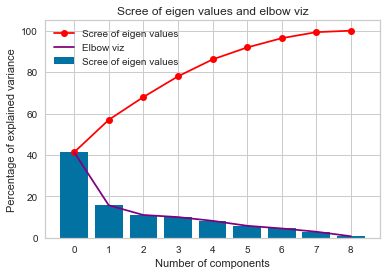

In [118]:
# Appel de la fonction d'affichage des données
display_scree_plot(model_pca.explained_variance_ratio_*100, model_pca.explained_variance_ratio_.cumsum()*100)

**Observation**<br>
On remarque ici que deux dimensions suffisent à expliquer + de la moitié (57%) de la variance des données.<br>
La méthode du coude indique que 2 composantes seraient suffisantes. <br>
Les valeurs propres > 1, et même quasiment > 1.44 avec le test plus restrictif, concernent les 2 premières composantes.
-----------

## Choix du nombre de composantes - Librairie fanalysis
Calcul de l'ACP avec la librairie fanalysis, plus simple pour gérer les graphiques liés à l'ACP (comme le cercle de corrélation)

In [119]:
from fanalysis.pca import PCA

fanalysis_PCA = PCA

pca_df=main_df.iloc[:,1:10].copy()

model2_pca = fanalysis_PCA(std_unit=True, row_labels=pca_df.index.values, col_labels=pca_df.columns.values) #std_unit to indicate if we normalize or not the data
res2_pca=model2_pca.fit_transform(pca_df.to_numpy())
#my_pca.fit(pca_df.to_numpy())

#my_pca.plot_eigenvalues(type="percentage") 

pd.DataFrame(model2_pca.eig_,index=["Valeur propre","% Variance expliquée","% Var. cumulée expliquée"])

,0,1,2,3,4,5,6,7,8
Valeur propre,3.714922,1.410511,0.989419,0.898269,0.735470,0.520546,0.403707,0.262061,0.065096
% Variance expliquée,41.276906,15.672342,10.993542,9.980770,8.171887,5.783840,4.485635,2.911786,0.723293
% Var. cumulée expliquée,41.276906,56.949248,67.942789,77.923559,86.095446,91.879286,96.364921,99.276707,100.000000


Affichage des vecteurs propres

In [120]:
pd.DataFrame(model2_pca.eigen_vectors_)

,0,1,2,3,4,5,6,7,8
0,-0.275532,-0.388106,0.104423,-0.039742,0.788032,0.025425,-0.000001,-0.371435,-0.036979
1,0.405792,0.006627,0.270602,0.164339,0.432953,0.229124,-0.137379,0.667246,0.176123
2,0.417138,-0.128603,0.036263,-0.064305,0.046553,-0.082998,0.888920,-0.061836,-0.030794
3,0.166186,-0.616046,0.245010,-0.279924,-0.198966,-0.580069,-0.230474,0.158603,-0.011874
4,0.474029,0.106298,0.069381,0.149544,-0.002684,-0.089310,-0.222631,-0.533547,0.628172
5,0.477861,0.143788,0.155669,0.124650,0.056958,0.008456,-0.248421,-0.277775,-0.754331
6,0.130436,-0.267671,-0.740982,0.531606,0.096530,-0.228693,-0.051692,0.112153,-0.053012
7,0.254013,-0.406358,-0.340447,-0.433593,-0.140419,0.651798,-0.131702,-0.067076,0.006326
8,-0.152323,-0.429569,0.400650,0.616775,-0.342806,0.343944,0.080835,-0.094503,-0.007629


**Observation**<br>
Ce tableau de composantes n'est pas ordonné comme il faut contrairement à eigen_vectors plus haut. Les lignes et les colonnes sont inverséses.<br>

F1 (voir plus bas) est une combinaison linéaire des autres variables.
On prend la ligne 0 des données centrées réduites et la ligne 0 du tableau 

J'ai pu vérifier le bon tableau en multipliant toutes les valeurs de la 1res lignes d'un tableau de vecteurs propres (puis l'autre pour comparer) par la 1re ligne du tableau de données centrées et réduites.
La somme doit donner la valeur de F1 de la variable concernée (https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5278723-interpretez-le-cercle-des-correlations)
_____________________

Affichage de l'éboulis des valeurs propres

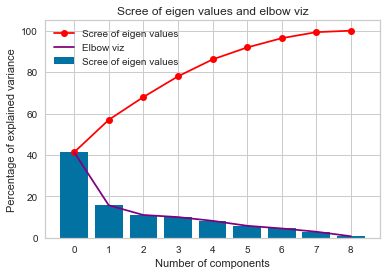

In [121]:
display_scree_plot(model2_pca.eig_[1],model2_pca.eig_[2])

**Observation**<br>
Le résultat entre les 2 méthodes est le même (avec des chiffres sensiblement différents qui ne changent pas les pourcentages finaux).<br>
On reste sur 2 composantes principales pour expliquer la variance de 57% de nos données.
_______________

## Analyse

Je vérifie que les variables sont bien décorrélées (même si je n'avais pas vérifié avant car on avait beaucoup de variables)

In [122]:
from scipy.stats import pearsonr

comp1=res2_pca[:,0]
comp2=res2_pca[:,1]
coef_corr_comp, p_value_comp = pearsonr(comp1, comp2)
print(coef_corr_comp, p_value_comp)

-1.457167719820518e-16 0.9999999999999878


**Observation**<br>
Il n'y a pas de corrélation linéaires entre les 2 composantes, le coefficient de corrélation est proche de 0 et une p-value valant 1, ce qui signifie qu'on accèpte l'hypothèse nulle (les varaiables sont indépendantes).<br>
L'ACP transforme un jeu de variables en un nouvel ensemble de variables non corrélées.
_____________________

Affichage 
- du cercle de corrélation regroupant les 2 1res composantes
- des tableaux de contribution des 2 variables du 1er plan factoriel. 

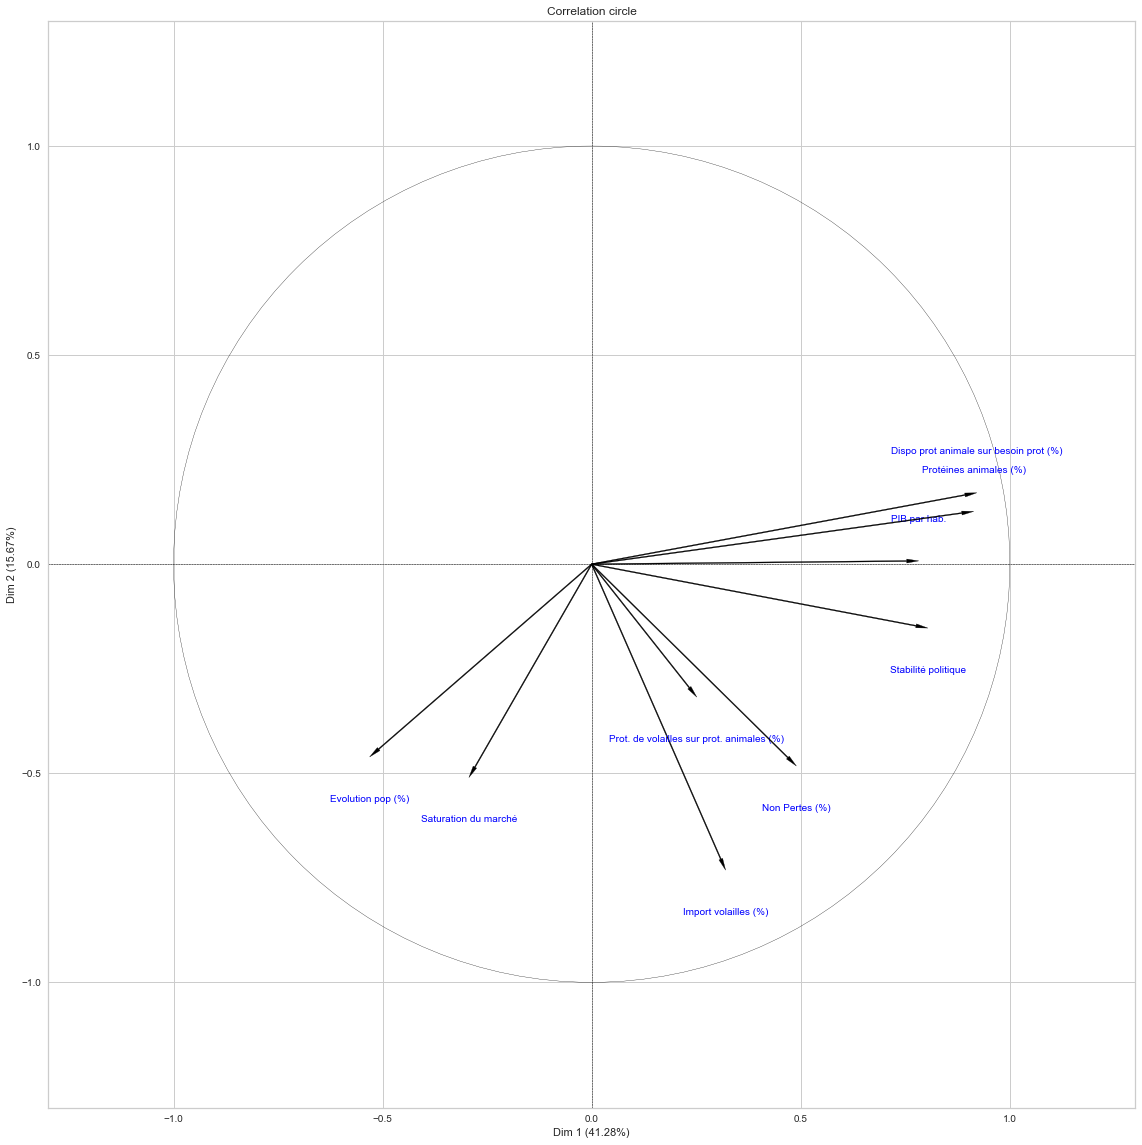

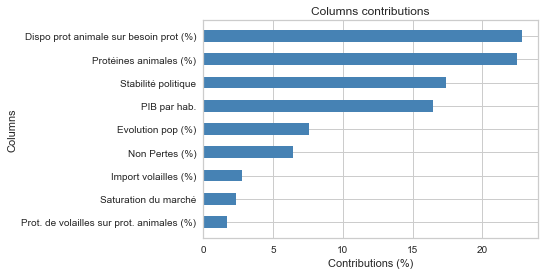

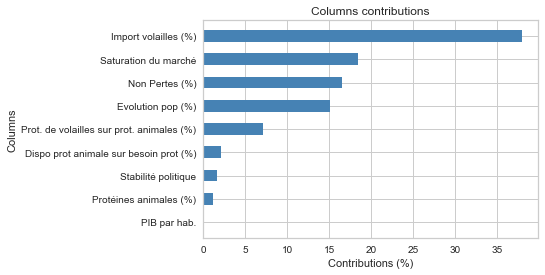

In [123]:
model2_pca.correlation_circle(num_x_axis=1, num_y_axis=2,figsize=(20,20))
#model2_pca.correlation_circle(num_x_axis=3, num_y_axis=4,figsize=(20,20))
model2_pca.plot_col_contrib(1,n_components)
model2_pca.plot_col_contrib(2,n_components)

**Observation**<br>
Les axes factoriels sont des axes virtuels issus d’une synthèse entre les variables de l’analyse. Ils n’ont pas nécessairement un sens précis même si on peut souvent leur trouver un sens en s’aidant notamment de la représentation des variable sur le cercle de corrélation.

Les 2 variables *Protéines animales* et *Dispo prot animale sur besoin prot (%)* sont très proches du cercle de corrélation et donc très bien représentés sur le mapping. l'**axe 1**. On peut avancer qu'elles sont corrélées entre elles (très faible angle entre les 2 et flèches proches de 1).<br>
On voit aussi une corrélation positive sur cet axe de *Stabilité politique* et *PIB*.<br>

L'*"import volailles"* est la variable qui contribue le + à l'**axe 2** mais est négativement. Les 4 variables participant à F2 sont négatives.<br>

La protéine de volaille n'a pas d'influence sur les 2 axes, la variable est mal représentée.

De ces observations, nous pouvons conclure que l'**axe 1** correspond aux pays plutôt carnivores (2 1res contributions) et riches (2 contributions suivantes). On pourrait extrapoler et résumer l'axe en **"Pays riches"** si on considère que les pays riches consomment plus de viande (même s'il y a des exceptions culturelles liées au statut de pays plutôt végétarien). <br>
L'**axe 2 renseignerait sur le marché** en lui-même.

_______________________

Validation majorité des cas : pays stables = pays riches. Faire varier le signe < > sur les 2 variables.

In [124]:
main_df[(main_df["Stabilité politique"]<=0)&(main_df["PIB par hab."]>np.mean(main_df["PIB par hab."]))].shape[0]

6

### Répartition individus et centroïds

In [125]:
print("Coordonnées des coefficients de corrélation des individus")
res2_pca_df=pd.DataFrame(res2_pca[:,0:2],columns=["F1","F2"], index=main_df.index)
#res2_pca_df=pd.DataFrame(res2_pca[:,0:4],columns=["F1","F2","F3","F4"], index=main_df.index) si 4 composantes
res2_pca_df

Coordonnées des coefficients de corrélation des individus


,F1,F2
Zone,,
Afghanistan,-3.513882,-0.027671
Afrique du Sud,-0.243065,-0.014286
Albanie,1.237112,0.246668
Algérie,-2.114817,0.954905
Allemagne,2.374577,0.009158
...,...,...
Émirats arabes unis,0.704956,-3.085007
Équateur,-0.877326,0.870166
États-Unis d'Amérique,3.044527,1.453808


In [126]:
final_df=pd.concat([main_df, res2_pca_df], axis=1)
final_df

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans,F1,F2
Zone,,,,,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0,5,1,-3.513882,-0.027671
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0,3,2,-0.243065,-0.014286
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0,3,3,1.237112,0.246668
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0,5,1,-2.114817,0.954905
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0,1,3,2.374577,0.009158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0,4,2,0.704956,-3.085007
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0,5,1,-0.877326,0.870166
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0,2,3,3.044527,1.453808


Calcul de la moyenne de chaque groupe et projection

In [127]:
centroid_CAH=final_df.groupby(by=["CAH"], as_index=False).agg({'F1':'mean','F2':"mean"})
#centroid_CAH=final_df.groupby(by=["CAH"], as_index=False).agg({'F1':'mean','F2':"mean",'F3':'mean','F4':"mean"}) si 4 composantes
centroid_CAH
#final_choice_prop1.groupby(by="Continent").agg(Total=('Continent','count'))

,CAH,F1,F2
0,1,3.184195,-0.429537
1,2,1.684810,1.826166
2,3,0.919071,-0.056451
3,4,-0.816883,-1.536478
4,5,-2.104973,0.544467


In [128]:
centroid_Kmeans=final_df.groupby(by=["Kmeans"], as_index=False).agg({'F1':'mean','F2':"mean"})
#centroid_Kmeans=final_df.groupby(by=["Kmeans"], as_index=False).agg({'F1':'mean','F2':"mean",'F3':'mean','F4':"mean"}) si 4 composantes
centroid_Kmeans

,Kmeans,F1,F2
0,1,-2.381153,0.586629
1,2,-0.560344,-0.712991
2,3,2.017048,0.341020


Projection des individus et des centroïds avec visualisation clustering CAH

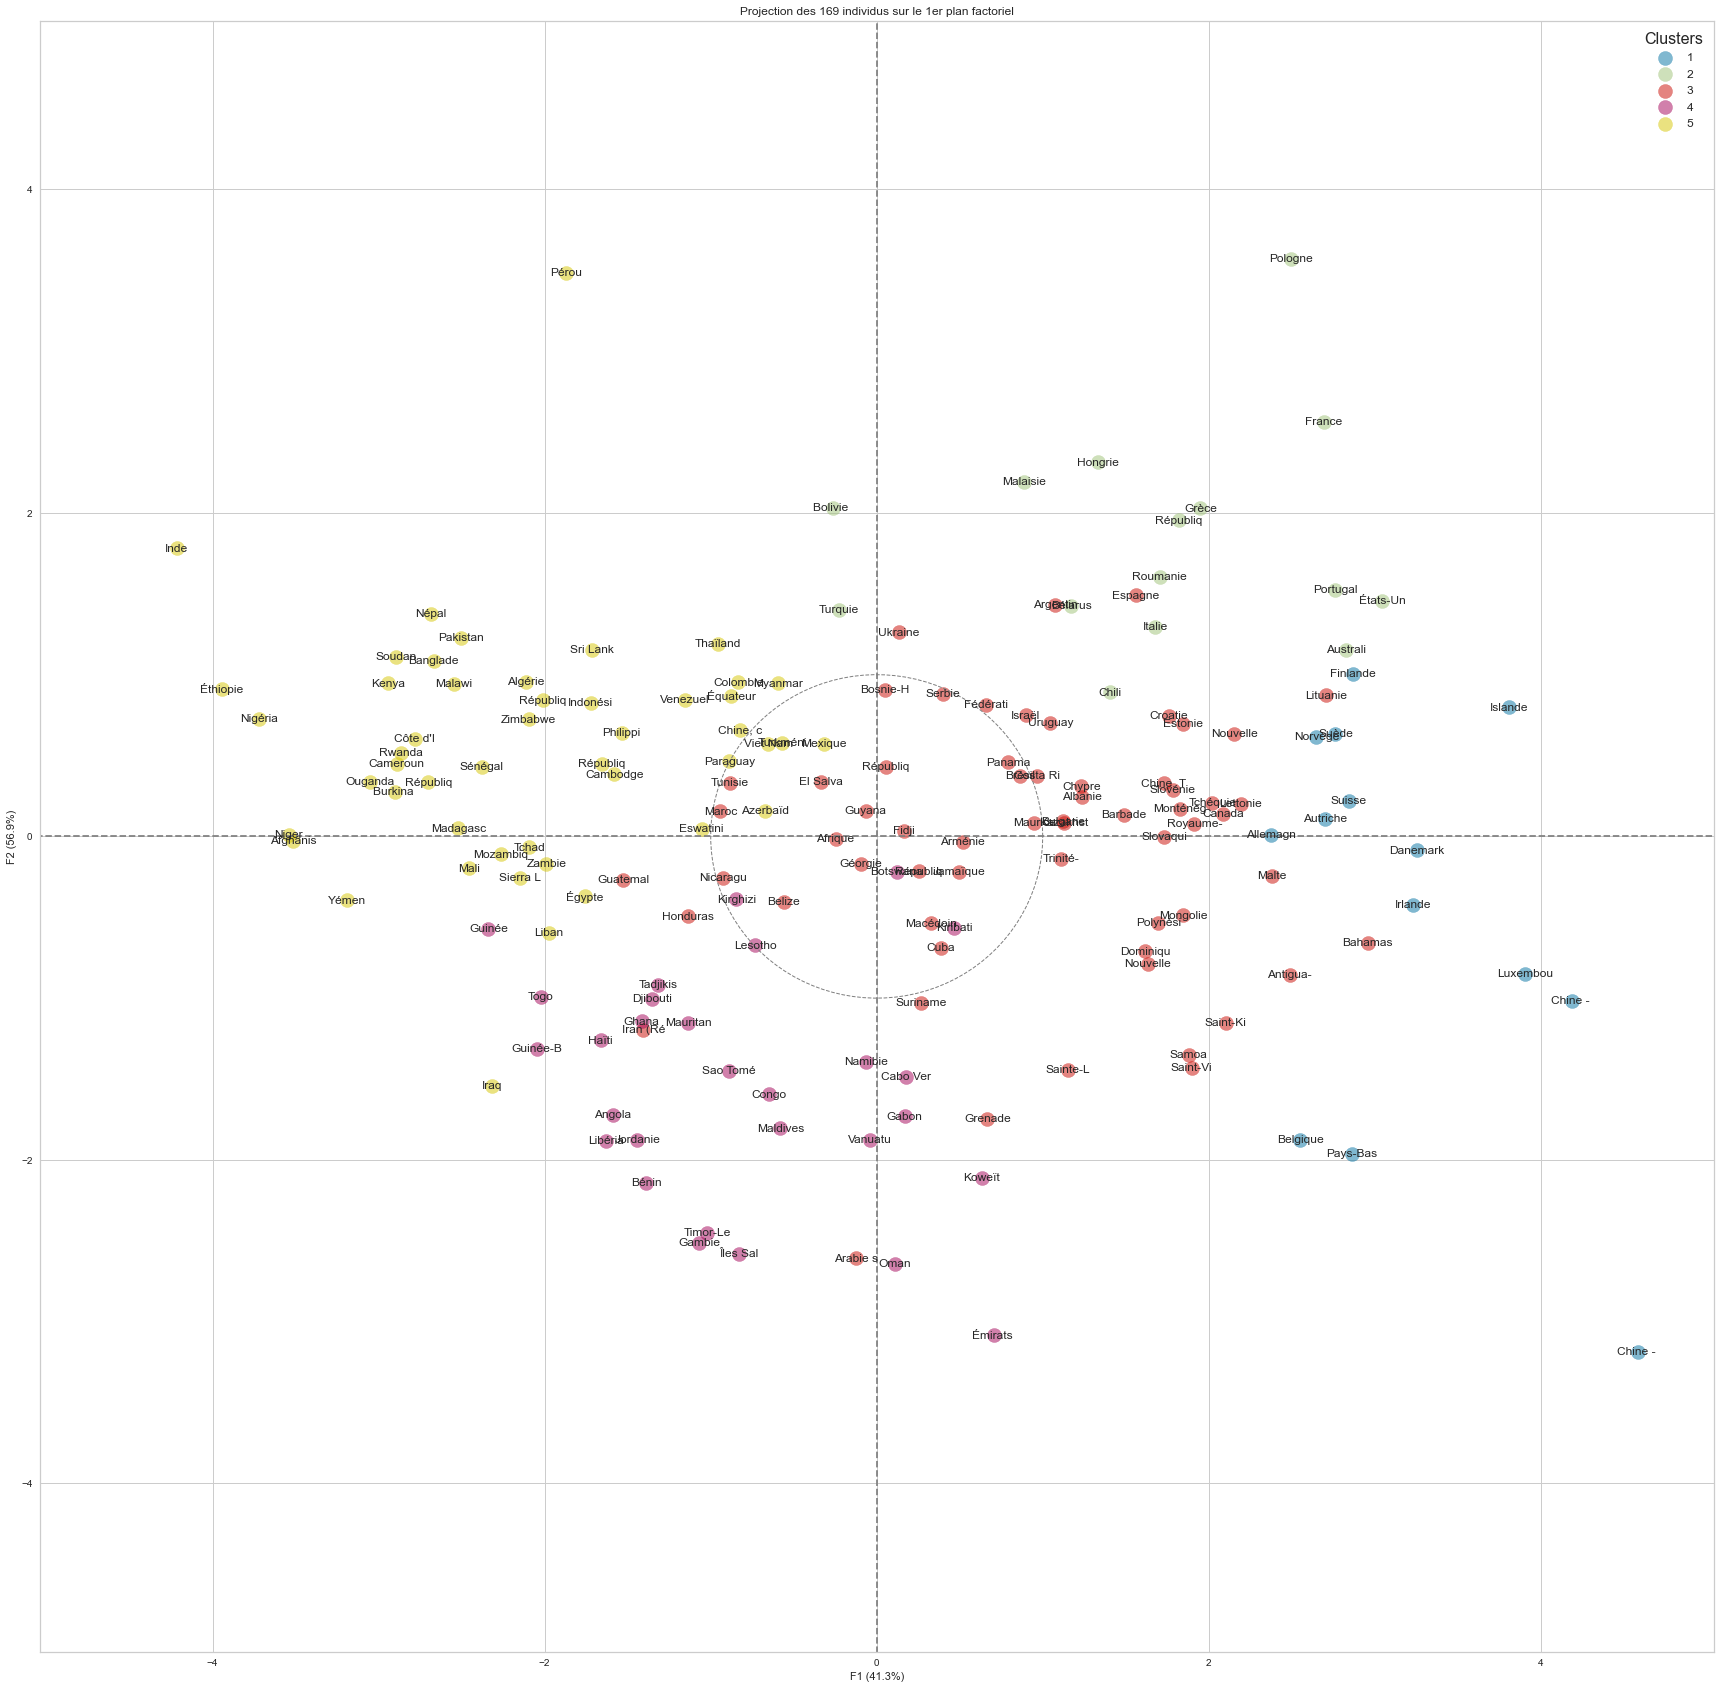

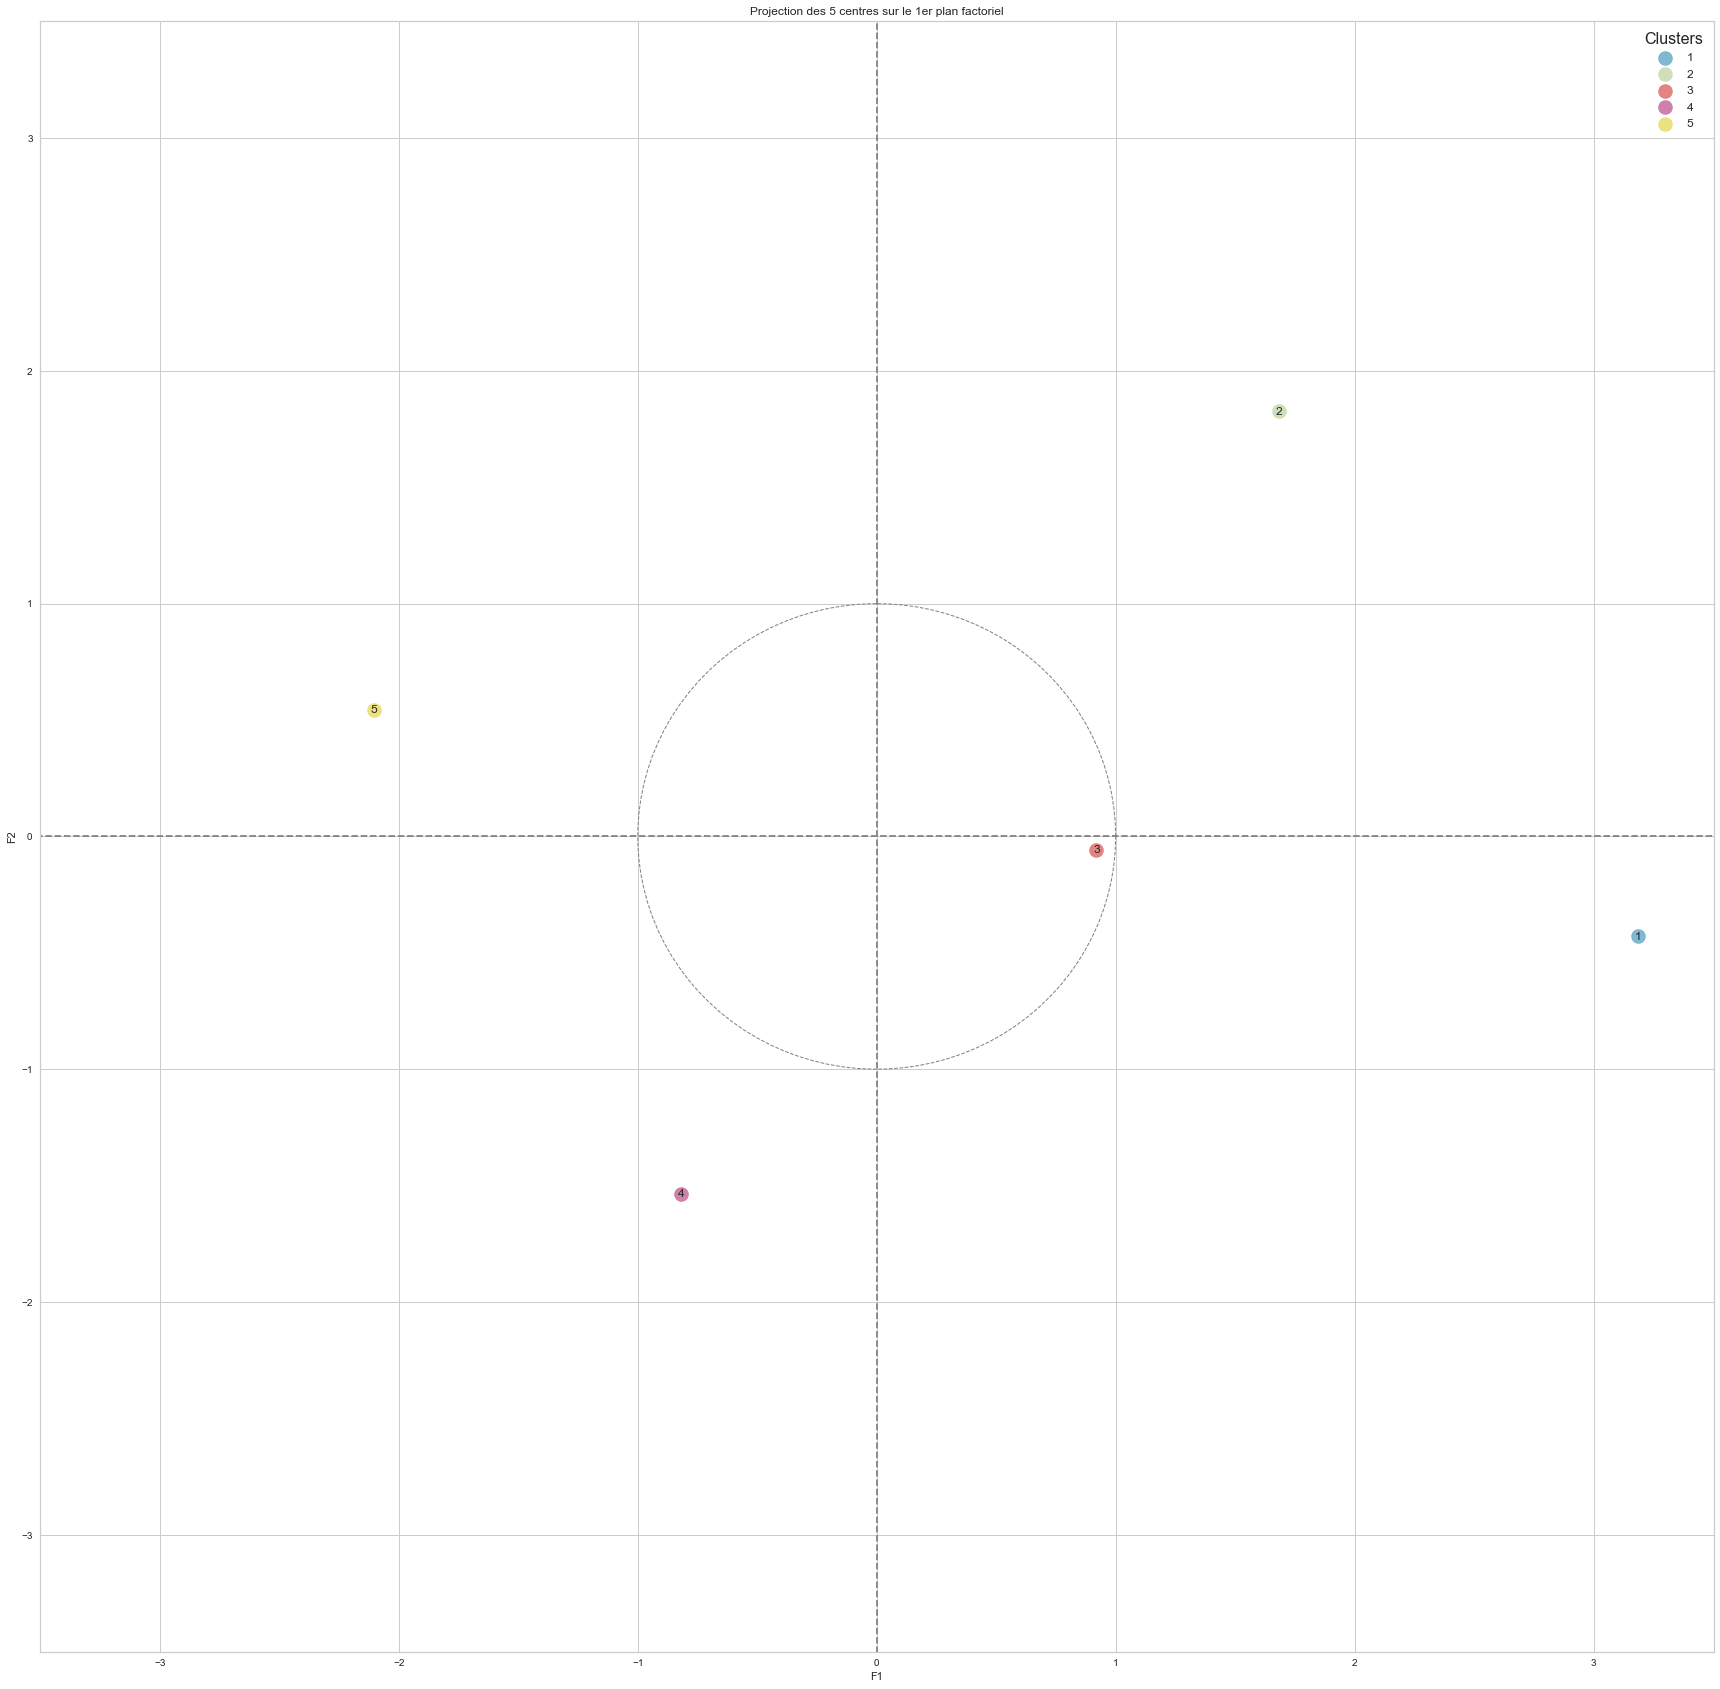

In [129]:
display_factorial_planes(X_projected=res2_pca, n_comp=n_components, pca=model2_pca, axis_ranks=[(0,1)],  alpha = 0.5, illustrative_var=main_df.CAH, title_type='individus',title_nb_of_indiv=res2_pca.shape[0],labels=main_df.index)

display_factorial_planes(X_projected=centroid_CAH.to_numpy(), n_comp=5, axis_ranks=[(1,2)], alpha = 0.5, illustrative_var=centroid_CAH.CAH, title_type='centres',title_nb_of_indiv=centroid_CAH.shape[0],labels=centroid_CAH.index+1)

**Observation**<br>
On recherchera plutôt des pays sous l'axe F1.<br>
On voit que les pays du groupe 5 se trouvent dans le quart haut gauche où ne sont positionnés aucune variable. Le groupe 4 a une bonne évolution de la population et un marché non saturé.<br>
Le groupe 3 est mal représenté.

Coordonnées des coefficients de corrélation des individus

# Clustering sur ACP
Faire un clustering sur l'ACP, sur les variables synthétiques. Il ne faut pas centrer et réduire pour ne pas éliminer l'importance entre les axes, on ne veut pas donner autant d'importance à chaque dimension.

In [130]:
final_df

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans,F1,F2
Zone,,,,,,,,,,,,,,
Afghanistan,Asie,3.39,2058.4,-2.57,50.88,19.78,21.57,5.05,96.49,0.0,5,1,-3.513882,-0.027671
Afrique du Sud,Afrique,1.61,13860.3,-0.06,24.27,42.83,71.98,39.52,96.08,0.0,3,2,-0.243065,-0.014286
Albanie,Europe,-0.49,12771.0,0.07,80.85,51.05,122.98,10.26,100.00,-8.0,3,3,1.237112,0.246668
Algérie,Afrique,2.11,11737.4,-1.17,0.72,26.93,50.40,7.88,95.31,0.0,5,1,-2.114817,0.954905
Allemagne,Europe,0.17,53071.5,0.82,48.42,60.54,127.02,12.63,100.00,57.0,1,3,2.374577,0.009158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,Asie,5.38,67183.6,0.80,105.10,32.07,69.35,43.02,100.00,51.0,4,2,0.704956,-3.085007
Équateur,Amériques,1.74,11617.9,-0.41,0.00,46.68,61.90,20.03,95.01,2.0,5,1,-0.877326,0.870166
États-Unis d'Amérique,Amériques,0.81,59914.8,0.52,0.67,64.25,147.18,27.30,100.00,-159.0,2,3,3.044527,1.453808


In [131]:
comp_df=final_df.iloc[:,[0,-2,-1]].copy()
comp_df_num=comp_df.iloc[:,[1,2]]
#comp_df=final_df.iloc[:,[0,-4,-3,-2,-1]].copy() si 4 composantes
#comp_df_num=comp_df.iloc[:,[1,2,3,4]]
comp_df_num

,F1,F2
Zone,,
Afghanistan,-3.513882,-0.027671
Afrique du Sud,-0.243065,-0.014286
Albanie,1.237112,0.246668
Algérie,-2.114817,0.954905
Allemagne,2.374577,0.009158
...,...,...
Émirats arabes unis,0.704956,-3.085007
Équateur,-0.877326,0.870166
États-Unis d'Amérique,3.044527,1.453808


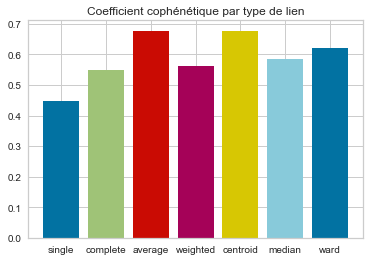

La meilleure méthode théorique de lien est la 'average'.


In [132]:
best_linkage_ach(comp_df_num)

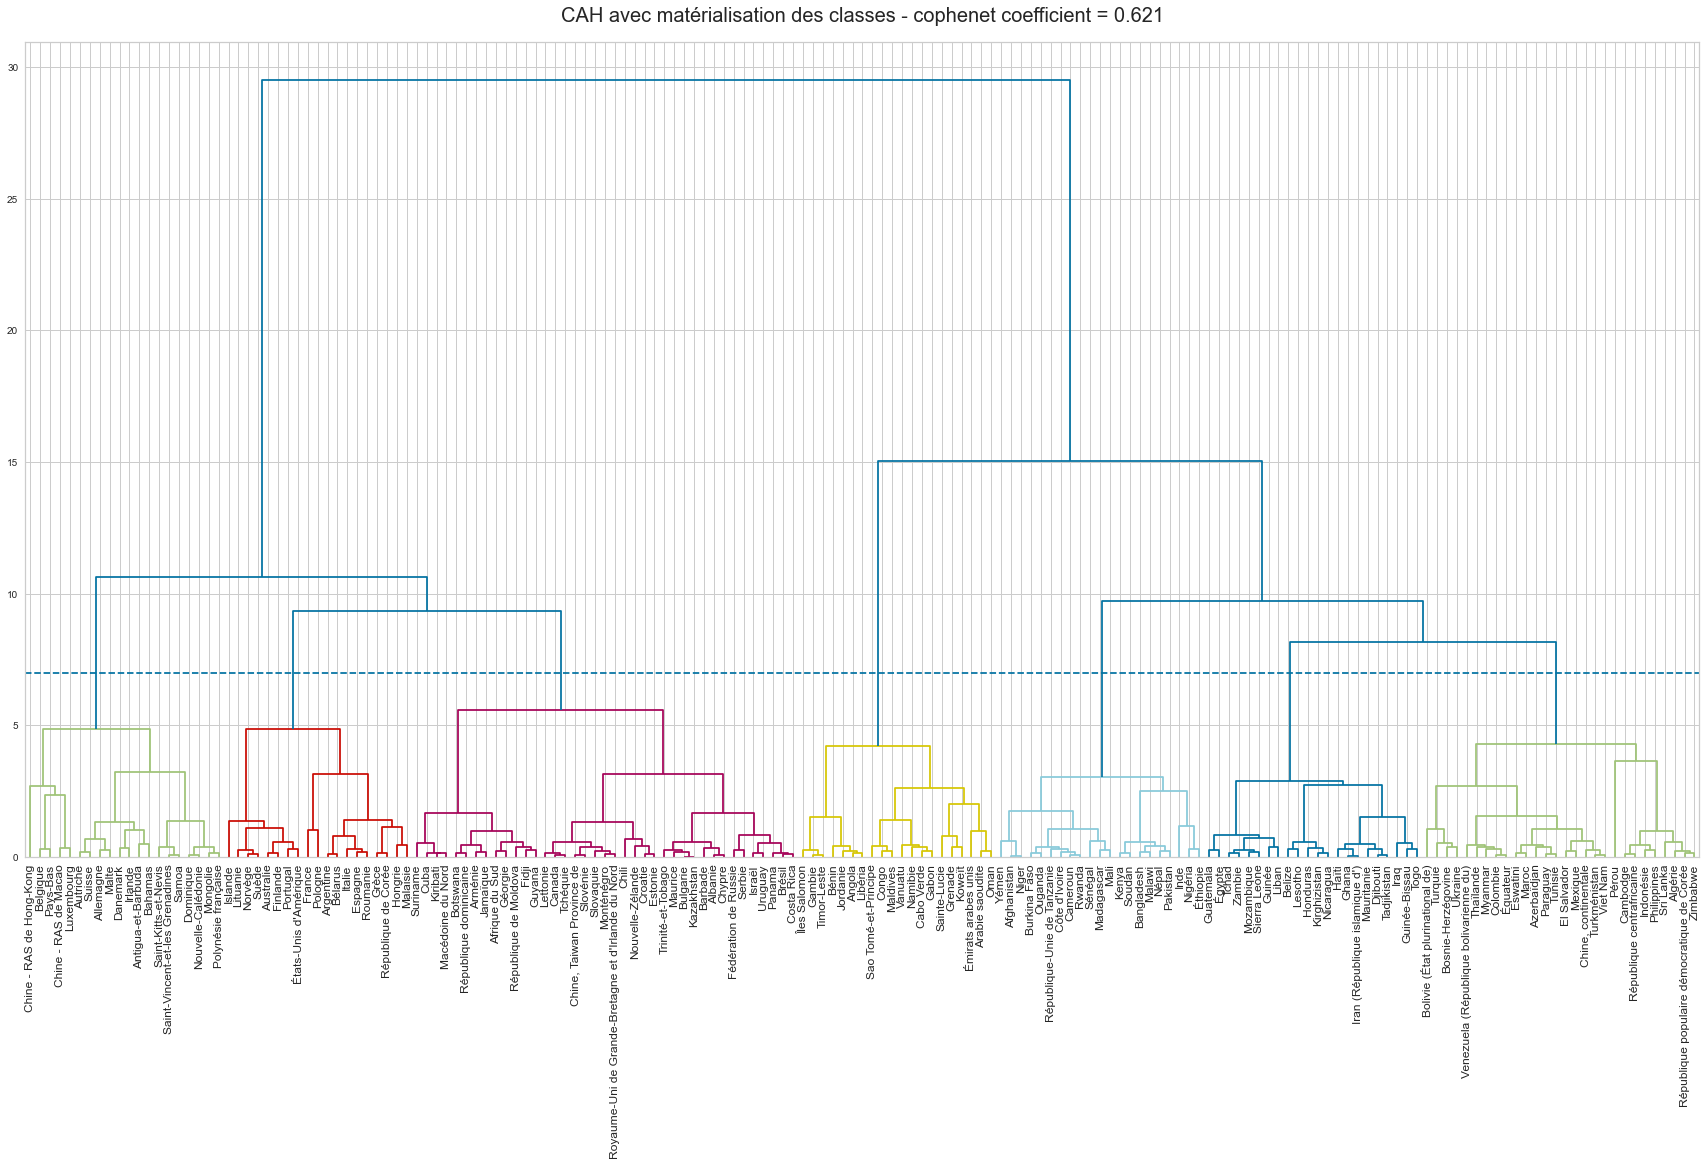

In [133]:
#plot_dendrogram(XCR,Z,13)
Z = linkage(comp_df_num, method="ward",metric="euclidean")
plot_dendrogram(comp_df_num,Z,7)

In [134]:
number_of_clusters=7 # Clusters are colored on the dendogram above
groups = fcluster(Z, number_of_clusters, criterion='maxclust') # ou fcluster(Z, threshold, criterion='distance')

display_countries_from_clusters(number_of_clusters, groups)

Affichage des 7 clusters

Cluster 1 :
Allemagne, Antigua-et-Barbuda, Autriche, Bahamas, Belgique, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Danemark, Dominique, Irlande, Luxembourg, Malte, Mongolie, Nouvelle-Calédonie, Pays-Bas, Polynésie française, Saint-Kitts-et-Nevis, Saint-Vincent-et-les Grenadines, Samoa, Suisse
 
Cluster 2 :
Argentine, Australie, Bélarus, Espagne, Finlande, France, Grèce, Hongrie, Islande, Italie, Lituanie, Malaisie, Norvège, Pologne, Portugal, Roumanie, République de Corée, Suède, États-Unis d'Amérique
 
Cluster 3 :
Afrique du Sud, Albanie, Arménie, Barbade, Botswana, Brésil, Bulgarie, Canada, Chili, Chine, Taiwan Province de, Chypre, Costa Rica, Croatie, Cuba, Estonie, Fidji, Fédération de Russie, Guyana, Géorgie, Israël, Jamaïque, Kazakhstan, Kiribati, Lettonie, Macédoine du Nord, Maurice, Monténégro, Nouvelle-Zélande, Panama, Royaume-Uni de Grande-Bretagne et d'Irlande du Nord, République de Moldova, République dominicaine, Serbie, Slovaquie, Slovénie, 

In [135]:
comp_df["CAH"]=groups

In [136]:
comp_df

,Continent,F1,F2,CAH
Zone,,,,
Afghanistan,Asie,-3.513882,-0.027671,5
Afrique du Sud,Afrique,-0.243065,-0.014286,3
Albanie,Europe,1.237112,0.246668,3
Algérie,Afrique,-2.114817,0.954905,7
Allemagne,Europe,2.374577,0.009158,1
...,...,...,...,...
Émirats arabes unis,Asie,0.704956,-3.085007,4
Équateur,Amériques,-0.877326,0.870166,7
États-Unis d'Amérique,Amériques,3.044527,1.453808,2


**Observation**<br>
3 groupes semble idéal, mais ce n'est pas assez pour proposer une solution sur quelques pays.<br>
Avec 7 clusters, les branches sont assez longues de chaque arbre.

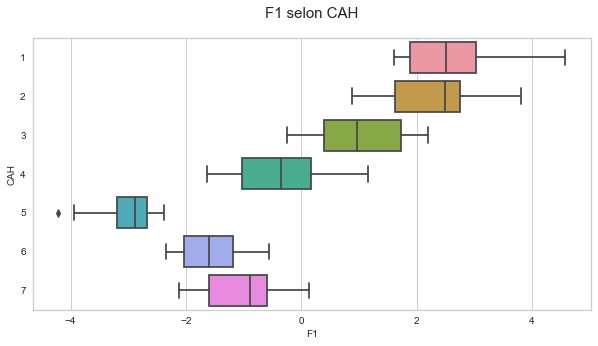

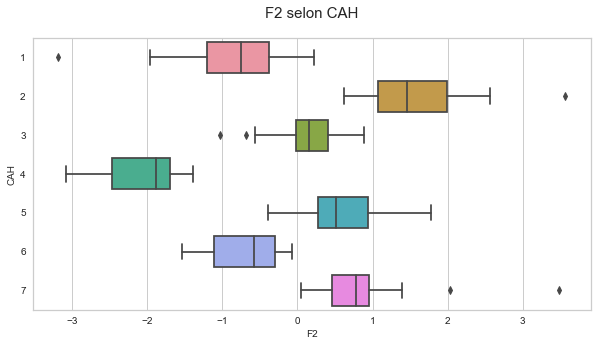

In [137]:
for item in comp_df.columns[1:len(comp_df.columns)-1]:
    build_plot(comp_df,item, "CAH")

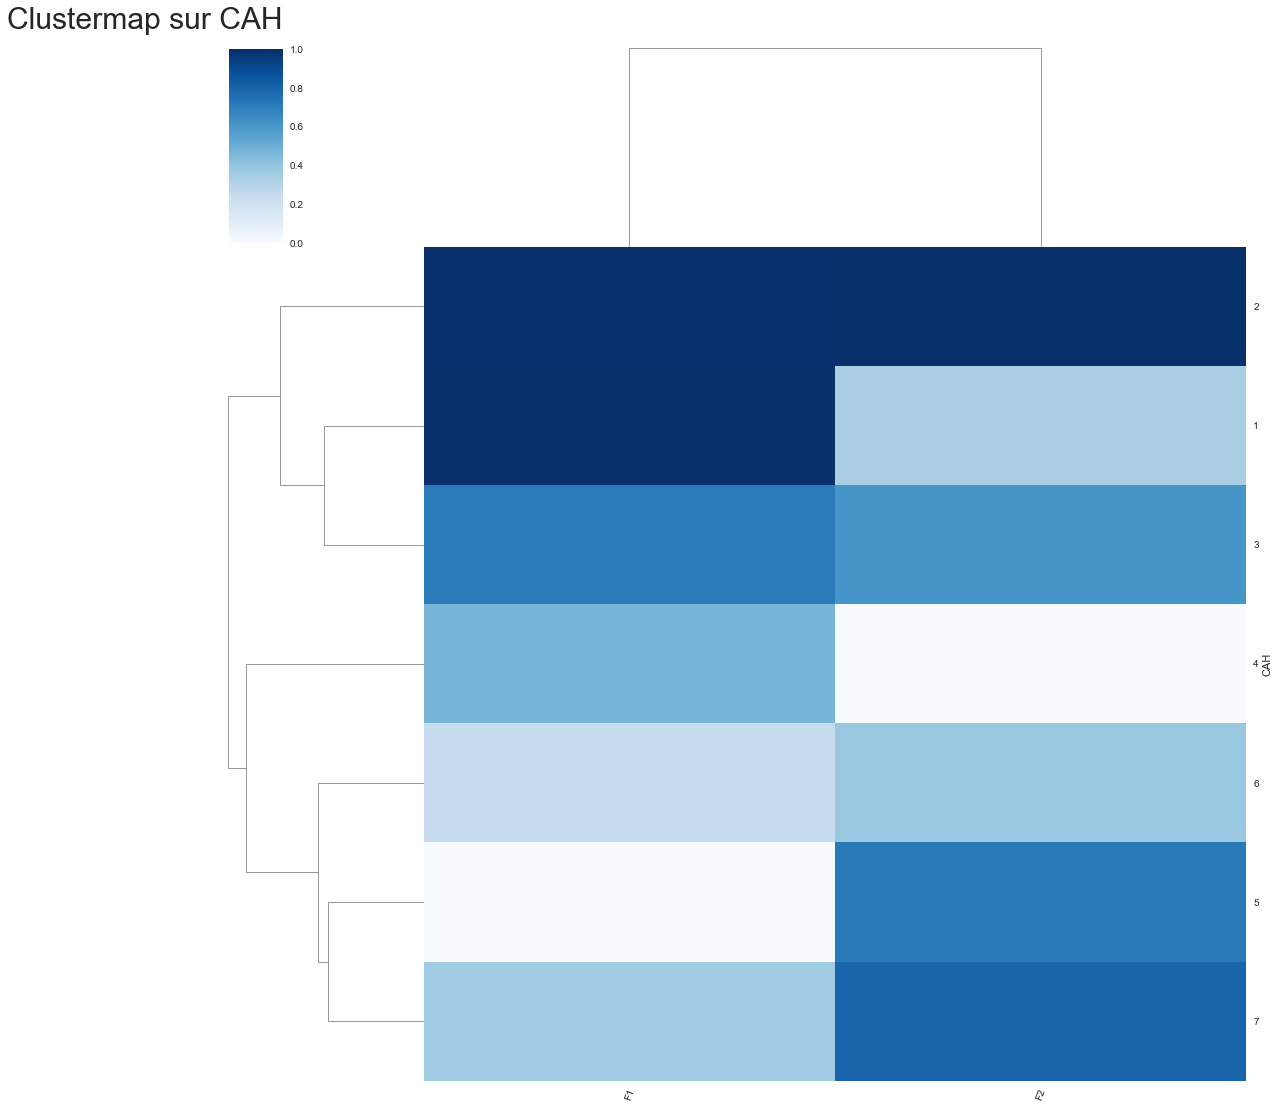

In [138]:
build_clustermap(comp_df[comp_df.columns.difference(["Continent"])],"CAH")

**Observation**<br>
Si F1 = richesse des pays, et F2 le marché, on se dirigerait vers les pays du groupe 2 qui a la meilleure ouverture de marché et un bon positionnement niveau richesse/carnivorisme.

In [139]:
list_group2=comp_df.index[comp_df["CAH"]==2]
list_group2

Index(['Argentine', 'Australie', 'Bélarus', 'Espagne', 'Finlande', 'France',
       'Grèce', 'Hongrie', 'Islande', 'Italie', 'Lituanie', 'Malaisie',
       'Norvège', 'Pologne', 'Portugal', 'Roumanie', 'République de Corée',
       'Suède', 'États-Unis d'Amérique'],
      dtype='object', name='Zone')

In [140]:
final_df[final_df.index.isin(list_group2)]

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans,F1,F2
Zone,,,,,,,,,,,,,,
Argentine,Amériques,1.07,23597.1,0.04,0.41,65.56,135.69,20.10,94.60,0.0,3,3,1.073744,1.429868
Australie,Océanie,1.75,48398.5,0.95,1.37,66.94,145.77,22.96,100.00,-143.0,2,3,2.826622,1.152487
Bélarus,Europe,-0.03,18356.1,0.15,7.92,52.08,98.79,19.20,100.00,-134.0,2,3,1.171975,1.423633
Espagne,Europe,0.27,39528.9,-0.02,13.69,62.34,134.48,18.70,95.59,-22.0,3,3,1.560786,1.490307
Finlande,Europe,0.40,47570.1,1.31,14.41,63.09,149.80,10.59,100.00,-44.0,1,3,2.867098,1.005175
France,Europe,0.48,44577.1,0.41,32.17,56.83,128.43,14.05,100.00,-366.0,2,3,2.692565,2.562225
Grèce,Europe,-0.50,28604.9,-0.05,44.38,56.12,118.95,10.71,100.00,-236.0,2,3,1.949586,2.027349
Hongrie,Europe,-0.29,29501.1,0.71,21.80,56.63,100.20,19.72,93.23,-148.0,2,3,1.332337,2.311805
Islande,Europe,0.96,55638.5,1.27,20.00,72.87,207.66,11.97,100.00,-3.0,1,3,3.809891,0.797794


**Observation**
Tous les pays font partie du groupe 3 kmeans qui a été éliminé à cause de sa haute saturation du marché. Visiblement la composante 2 ne réprésente pas cette variable.
______________________

In [141]:
list_group4=comp_df.index[comp_df["CAH"]==4]
final_df[final_df.index.isin(list_group4)]

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans,F1,F2
Zone,,,,,,,,,,,,,,
Angola,Afrique,4.26,7310.9,-0.39,86.83,29.03,31.65,22.93,99.37,0.0,4,2,-1.589118,-1.723941
Arabie saoudite,Asie,3.14,47306.2,-0.45,50.31,39.54,69.76,45.00,100.00,215.0,3,2,-0.121978,-2.609289
Bénin,Afrique,3.22,3044.5,0.22,76.40,20.64,26.81,37.44,100.00,40.0,4,2,-1.388432,-2.142586
Cabo Verde,Afrique,1.31,6643.2,0.78,120.00,37.07,51.81,25.37,100.00,-8.0,4,2,0.174560,-1.487162
Congo,Afrique,3.19,4234.7,-0.48,94.55,44.94,50.40,29.80,100.00,-1.0,4,2,-0.650453,-1.594346
Gabon,Afrique,4.02,15006.8,0.18,97.44,49.55,79.23,26.95,100.00,-3.0,4,2,0.167931,-1.731293
Gambie,Afrique,3.50,2072.6,-0.03,200.00,28.36,36.29,6.89,100.00,-20.0,4,2,-1.067701,-2.513711
Grenade,Amériques,0.54,16217.5,0.60,87.50,36.04,51.27,60.95,100.00,0.0,3,2,0.666522,-1.745826
Jordanie,Asie,5.64,10003.6,-0.46,23.27,34.74,48.39,42.08,100.00,21.0,4,2,-1.441317,-1.878221


## Conclusion
Il n'est pas possible de tirer une conclusion sur la base des 2 composantes principales.<br>
On reste sur les recommandations faites sur l'analyse des clusters avant ACP.

In [142]:
final_choice_prop1

,Continent,Evolution pop (%),PIB par hab.,Stabilité politique,Import volailles (%),Protéines animales (%),Dispo prot animale sur besoin prot (%),Prot. de volailles sur prot. animales (%),Non Pertes (%),Saturation du marché,CAH,Kmeans
Zone,,,,,,,,,,,,
Angola,Afrique,4.26,7310.9,-0.39,86.83,29.03,31.65,22.93,99.37,0.0,4,2
Botswana,Afrique,1.76,15948.0,1.03,42.86,43.02,56.45,4.25,100.00,-1.0,4,2
Bénin,Afrique,3.22,3044.5,0.22,76.40,20.64,26.81,37.44,100.00,40.0,4,2
Cabo Verde,Afrique,1.31,6643.2,0.78,120.00,37.07,51.81,25.37,100.00,-8.0,4,2
Congo,Afrique,3.19,4234.7,-0.48,94.55,44.94,50.40,29.80,100.00,-1.0,4,2
Djibouti,Afrique,1.72,4905.0,-0.13,100.00,22.13,29.64,6.26,100.00,0.0,4,2
Gabon,Afrique,4.02,15006.8,0.18,97.44,49.55,79.23,26.95,100.00,-3.0,4,2
Gambie,Afrique,3.50,2072.6,-0.03,200.00,28.36,36.29,6.89,100.00,-20.0,4,2
Ghana,Afrique,2.68,5115.9,0.01,71.56,23.35,29.64,15.37,100.00,0.0,4,2
